In [14]:
#
import numpy as np
import os, sys

sys.path.insert(0, '/global/homes/q/qmxp55/DESI/bgstargets/py')

from io_ import get_sweep_whole, getBGSbits, flux_to_mag
from io_ import get_random, get_isdesi, get_dict, bgsmask, get_reg, get_svfields, gaiaAEN
from cuts import getGeoCuts, bgsbut
from QA import getStats, flow, mollweide, mycmap, plot_sysdens, overdensity, hexbin

import healpy as hp
import astropy.io.fits as fits
import fitsio
import matplotlib.pyplot as plt
from matplotlib import gridspec
import matplotlib
from astropy.coordinates import SkyCoord
import astropy.units as units

%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings('ignore')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
#
dr = 'dr8'
survey = 'south' #is either south (DECaLS+DES) or north (BASS/MzLS)
version = '0.1.0'
filesdir = '/global/cscratch1/sd/qmxp55/bgstargets_output/'
Nranfiles = 3
reg = 'south'
dec_resol_ns = 32.375
if (dr == 'dr9sv'): Nranfiles = 20 # because the randoms for dr9d have a density of 100000 = 5000*20

pathdir = os.path.abspath(os.getcwd())+'/%s-%s_%s_%s_draft_plots' %(dr, survey, reg, version)
ispathdir = os.path.isdir(pathdir)
if not ispathdir: os.mkdir(pathdir)

# for healpy
dr8pix     = '/project/projectdirs/desi/target/catalogs/dr8/0.31.1/pixweight/pixweight-dr8-0.31.1.fits'
hdr          = fits.getheader(dr8pix,1)
nside,nest   = hdr['hpxnside'],hdr['hpxnest']
npix         = hp.nside2npix(nside)
pixarea      = hp.nside2pixarea(nside,degrees=True)

In [3]:
#load catalogues
if dr == 'dr9sv': N = 1
else: N = Nranfiles
    
cat = np.load(filesdir+dr+'/'+version+'/'+'bgstargets-'+survey+'.npy')
cat_ex = np.load(filesdir+dr+'/'+version+'/'+'extra-'+survey+'_n256.npy')
ran = np.load(filesdir+dr+'/'+dr+'_random_N'+str(N)+'.npy')
ran_ex = np.load(filesdir+dr+'/'+'extra_random_N'+str(N)+'_n256.npy')

In [4]:
hppix_ran = ran_ex['hppix']
ranindesi = ran_ex['desi']
raninreg = (ran_ex[reg]) & (ran_ex['desi'])

hppix_cat = cat_ex['hppix']
catindesi = cat_ex['desi']
catinreg = (cat_ex[reg]) & (cat_ex['desi'])


## Skymap footprint
Below code only needs the randoms.

area_all: 	 20332.475(whole) 	 14265.679(desifootprint)
bgsarea_south: 	 15173.940(whole) 	 9716.980(desifootprint)
bgsarea_north: 	 5158.535(whole) 	 4548.699(desifootprint)
bgsarea_des: 	 5060.633(whole) 	 1113.520(desifootprint)
NGC DECaLS in DESI footprint: 	 5322.602
SGC DECaLS in DESI footprint: 	 4394.378


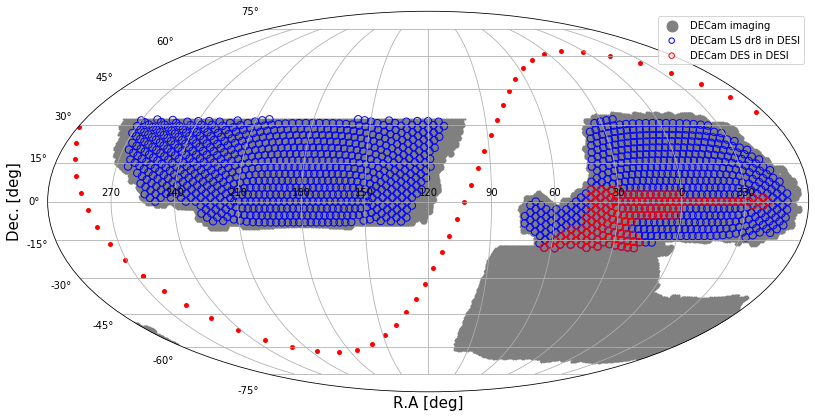

In [5]:
#
from QA import set_mwd, get_radec_mw
from io_ import get_isdes

# dict without geometrical mask and in WHOLE SWEEPS footprint
hpdict0 = get_dict(cat=None, pixmapfile=dr8pix, hppix_ran=hppix_ran, hppix_cat=None, 
                      maskrand=None, maskcat=None, Nranfiles=Nranfiles, ranindesi=ranindesi, catindesi=None, 
                            desifootprint=False, namesels=None, target_outputs=False, log=False)
# dict without geometrical mask and in DESI footprint
hpdict1 = get_dict(cat=None, pixmapfile=dr8pix, hppix_ran=hppix_ran, hppix_cat=None, 
                      maskrand=None, maskcat=None, Nranfiles=Nranfiles, ranindesi=ranindesi, catindesi=None, 
                            desifootprint=True, namesels=None, target_outputs=False, log=False)

#
for i in ['area_all', 'bgsarea_south', 'bgsarea_north', 'bgsarea_des']:
    print('%s: \t %.3f(whole) \t %.3f(desifootprint)' %(i, hpdict0[i], hpdict1[i]))
    
if survey == 'south':
    # DECaLS area in the NGC/SGC within DESI footprint
    area_decals_ngc = hpdict1['bgsfracarea'][(hpdict1['issouth']) & (hpdict1['galb'] > 0)].sum() * pixarea
    area_decals_sgc = hpdict1['bgsfracarea'][(hpdict1['issouth']) & (hpdict1['galb'] < 0)].sum() * pixarea
    print('NGC DECaLS in DESI footprint: \t %.3f' %(area_decals_ngc))
    print('SGC DECaLS in DESI footprint: \t %.3f' %(area_decals_sgc))
    
if survey == 'north':
    # DECaLS area in the NGC/SGC within DESI footprint
    area_bass_ngc = hpdict1['bgsfracarea'][(hpdict1['isnorth']) & (hpdict1['galb'] > 0)].sum() * pixarea
    print('NGC BASS/MzLS in DESI footprint: \t %.3f' %(area_bass_ngc))

desitiles = fitsio.read('/global/homes/q/qmxp55/desi-tiles-viewer.fits')
org          = 120  # centre ra for mollweide plots
projection   = 'mollweide'

# plotting bgsfracarea
fig = plt.figure(figsize=(14, 7))
gs = gridspec.GridSpec(1,1,wspace=0.15,hspace=0)

ax = plt.subplot(gs[0],projection=projection)
_ = set_mwd(ax,org=org)
ramw,decmw = get_radec_mw(hpdict0['ra'],hpdict0['dec'],org)
tmp        = (hpdict0['bgsfracarea']>0) & (hpdict0['is'+survey])
if survey == 'south':
    SC         = ax.scatter(ramw[tmp],decmw[tmp],s=0.4, color='gray', label=r'DECam imaging')
if survey == 'north':
    SC         = ax.scatter(ramw[tmp],decmw[tmp],s=0.4, color='gray', label=r'BASS/MzLS imaging')

ramw,decmw = get_radec_mw(desitiles['ra'],desitiles['dec'],org)
if survey == 'south':
    tmp = (desitiles['in_desi'] ==  1) & (desitiles['dec'] < dec_resol_ns)
    SC         = ax.scatter(ramw[tmp],decmw[tmp], marker='.', s = 220, facecolors='none', edgecolors='blue', label=r'DECam LS dr8 in DESI')
if survey == 'north':
    tmp = (desitiles['in_desi'] ==  1) & (desitiles['dec'] > dec_resol_ns)
    SC         = ax.scatter(ramw[tmp],decmw[tmp], marker='.', s = 220, facecolors='none', edgecolors='blue', label=r'BASS/MzLS dr8 in DESI')


if survey == 'south':
    desitilesindes = get_isdes(desitiles['ra'],desitiles['dec'])
    tmp = (desitiles['in_desi'] ==  1) & (desitiles['dec'] < dec_resol_ns) & (desitilesindes)
    SC         = ax.scatter(ramw[tmp],decmw[tmp], marker='.', s = 220, facecolors='none', edgecolors='red', label=r'DECam DES in DESI')

gc = SkyCoord(l=np.linspace(0, 360, 50)*units.degree, b=np.full(50, 0)*units.degree, frame='galactic')
ramw,decmw = get_radec_mw(gc.icrs.ra.value, gc.icrs.dec.value,org)
SC         = ax.scatter(ramw, decmw, color='r', marker='.', lw=2)

lgnd = ax.legend()
[handle.set_sizes([120.0]) for handle in lgnd.legendHandles]

fig.savefig('%s/skyplot_%s.png' %(pathdir, survey), bbox_inches = 'tight', pad_inches = 0)


## get area by number of passes + skymap of regions

In [7]:
# get the area covered by the number of passes from 1 to 3 and per band and for the joint bands.
Apasses = {}
for i in [0, 1, 2]:
    for j in ['G', 'R', 'Z', 'all']:
        
        if j == 'all': mask = (ran['NOBS_G'] > i) & (ran['NOBS_R'] > i) & (ran['NOBS_Z'] > i)
        else: mask = (ran['NOBS_'+j] > i)
            
        hpdicttest = get_dict(pixmapfile=dr8pix, hppix_ran=hppix_ran, maskrand=mask, Nranfiles=Nranfiles, 
                              ranindesi=ranindesi, desifootprint=True, target_outputs=False)
        
        for k in ['south', 'north', 'decals', 'des']:
            Apasses[j+str(i+1)+'_'+k] = hpdicttest['bgsarea_'+k]
        Apasses[j+str(i+1)+'_'+'all'] = hpdicttest['area_all']
            
        print('%s >= %i: \t south: %2.3g, north: %2.3g, decals: %2.3g, des: %2.3g, all: %2.3g' 
              %(j, i+1, hpdicttest['bgsarea_south'], hpdicttest['bgsarea_north'], hpdicttest['bgsarea_decals'], 
                    hpdicttest['bgsarea_des'], hpdicttest['area_all']))

G >= 1: 	 south: 9.69e+03, north: 4.54e+03, decals: 8.57e+03, des: 1.11e+03, all: 1.42e+04
R >= 1: 	 south: 9.69e+03, north: 4.54e+03, decals: 8.57e+03, des: 1.11e+03, all: 1.42e+04
Z >= 1: 	 south: 9.69e+03, north: 4.54e+03, decals: 8.57e+03, des: 1.11e+03, all: 1.42e+04
all >= 1: 	 south: 9.67e+03, north: 4.52e+03, decals: 8.56e+03, des: 1.11e+03, all: 1.42e+04
G >= 2: 	 south: 9.45e+03, north: 4.49e+03, decals: 8.34e+03, des: 1.11e+03, all: 1.39e+04
R >= 2: 	 south: 9.42e+03, north: 4.49e+03, decals: 8.31e+03, des: 1.11e+03, all: 1.39e+04
Z >= 2: 	 south: 9.49e+03, north: 4.49e+03, decals: 8.37e+03, des: 1.11e+03, all: 1.4e+04
all >= 2: 	 south: 9.26e+03, north: 4.41e+03, decals: 8.15e+03, des: 1.11e+03, all: 1.37e+04
G >= 3: 	 south: 7.77e+03, north: 3.93e+03, decals: 6.66e+03, des: 1.11e+03, all: 1.17e+04
R >= 3: 	 south: 7.57e+03, north: 3.9e+03, decals: 6.46e+03, des: 1.11e+03, all: 1.15e+04
Z >= 3: 	 south: 8.04e+03, north: 3.89e+03, decals: 6.93e+03, des: 1.11e+03, all: 1.19e+

In [8]:
#
print('BAND \t >= 1 \t\t >= 2 \t\t >= 3')
print('------------------------------------------')
for band in ['G', 'R', 'Z', 'all']:
    lab1 = band+'1'+'_south'
    lab2 = band+'2'+'_south'
    lab3 = band+'3'+'_south'
    
    print('%s: \t %.0f \t %.0f \t %.0f' %(band, Apasses[lab1], Apasses[lab2], Apasses[lab3]))


BAND 	 >= 1 		 >= 2 		 >= 3
------------------------------------------
G: 	 9687 	 9454 	 7769
R: 	 9686 	 9422 	 7569
Z: 	 9686 	 9487 	 8036
all: 	 9669 	 9257 	 6870


## Filter catalogue and randoms by region

In [6]:
#RANDOMS
keep = raninreg
ran = ran[keep]
ran_ex = ran_ex[keep]
ranindesi = ranindesi[keep]
hppix_ran = hppix_ran[keep]
raninreg = raninreg[keep]

#CATALOGUE
keepC = catinreg
cat = cat[keepC]
cat_ex = cat_ex[keepC]
catindesi = catindesi[keepC]
hppix_cat = hppix_cat[keepC]
catinreg = catinreg[keepC]


In [7]:
#bgsmask = bgsmask()
rancuts = getGeoCuts(ran, randoms=True)

## getting area of reg with healpix pixels (for flow charts...)

NOTE: if using SVFIELDS footprint, use `desifootprint=False` otherwise the area will be less than the current SVFIELDS due desi footprint chops out part of it.

In [8]:
#Notes: This hpdict is used to get the area only using the randoms. 
#This use the randoms within the DESI footprint and without any masking (maskrand=None) as we want the area without wholes.
hpdict0 = get_dict(cat=None, pixmapfile=dr8pix, hppix_ran=hppix_ran, hppix_cat=None, 
                      maskrand=None, maskcat=None, Nranfiles=Nranfiles, ranindesi=ranindesi, catindesi=None, 
                            desifootprint=True, namesels=None, target_outputs=False, log=True)

positions and desifotprint DONE...
systematics DONE...
randdens =  15000  ; len randoms =  145754705
bgsfracarea DONE...
regions DONE...
areas DONE...


## Healpy pixels catalogue with BGS target density (for dens. sky maps and systematics plots...)

In [9]:
#from astropy.coordinates import SkyCoord
#import astropy.units as units

#c = SkyCoord(cat['RA']*units.degree,cat['DEC']*units.degree, frame='icrs')
#galb = c.galactic.b.value # galb coordinate

In [10]:
#dic with default BGS selection and in DESI footprint
hpdict = get_dict(cat=cat, pixmapfile=dr8pix, hppix_ran=hppix_ran, hppix_cat=hppix_cat, 
                      maskrand=((rancuts['BS']) & (rancuts['GC']) & (rancuts['LG']) & (rancuts['nobs'])),
                          maskcat=None, 
                             Nranfiles=Nranfiles, ranindesi=ranindesi, catindesi=None, 
                                desifootprint=True, namesels={'bgs_any':20, 'bright':21, 'faint':22}, 
                                  galb=cat_ex['b'], log=True, survey='bgs')

positions and desifotprint DONE...
systematics DONE...
randdens =  15000  ; len randoms =  145754705
bgsfracarea DONE...
regions DONE...
areas DONE...
computing for  north / bgs_any
computing for  north / bright
computing for  north / faint
target densities in north DONE...
computing for  south / bgs_any
computing for  south / bright
computing for  south / faint
target densities in south DONE...
meandens_bgs_any_all = 1425 /deg2
meandens_bgs_any_des = 1430 /deg2
meandens_bgs_any_decals = 1425 /deg2
meandens_bgs_any_north = nan /deg2
meandens_bgs_any_south = 1425 /deg2
meandens_bgs_any_svfields = 1454 /deg2
meandens_bgs_any_svfields_n = nan /deg2
meandens_bgs_any_svfields_s = 1454 /deg2
meandens_bright_all = 847 /deg2
meandens_bright_des = 850 /deg2
meandens_bright_decals = 846 /deg2
meandens_bright_north = nan /deg2
meandens_bright_south = 847 /deg2
meandens_bright_svfields = 858 /deg2
meandens_bright_svfields_n = nan /deg2
meandens_bright_svfields_s = 858 /deg2
meandens_faint_all = 57

## BGS outline

In [16]:
#
bgs_any = ((cat['BGSBITS'] & 2**(20)) != 0)
bgs_b = ((cat['BGSBITS'] & 2**(21)) != 0)
bgs_f = ((cat['BGSBITS'] & 2**(22)) != 0)


print('mean density of BGS: \t %.2f' %(hpdict['meandens_bgs_any_'+survey]))
print('Area within BGS: \t %.2f' %(hpdict['bgsarea_'+survey]))

print('No BGS galaxies in Bright and Faint: \t %i \t %i \t %i' %(
    np.sum(bgs_b),
    np.sum(bgs_f),
    np.sum(bgs_any)
))


print('Overall density of BGS: \t %d \t %d \t %d' %(
    np.round(hpdict['dens_bright_'+survey], 0),
    np.round(hpdict['dens_faint_'+survey], 0),
    np.round(hpdict['dens_bgs_any_'+survey], 0)
))

print('morph \t BRIGHT \t FAINT \t OVERALL')
print('------------------------------------')
for morph in list(set(cat['TYPE'][:10000])):
    
    keep = cat['TYPE'] == morph
    print('%s \t %d \t %d \t %d' %(
        morph, 
        np.round(np.sum((keep) & (bgs_b))/hpdict['bgsarea_'+survey], 0),
        np.round(np.sum((keep) & (bgs_f))/hpdict['bgsarea_'+survey], 0),
        np.round(np.sum((keep) & (bgs_any))/hpdict['bgsarea_'+survey], 0),
        ))


mean density of BGS: 	 1425.23
Area within BGS: 	 9401.06
No BGS galaxies in Bright and Faint: 	 7944975 	 5433087 	 13378062
Overall density of BGS: 	 845 	 578 	 1423
morph 	 BRIGHT 	 FAINT 	 OVERALL
------------------------------------
COMP 	 27 	 3 	 31
DEV  	 427 	 202 	 629
REX  	 104 	 141 	 246
PSF  	 3 	 2 	 5
EXP  	 284 	 230 	 514


## BGS dens. sky maps

In [ ]:
from QA import mollweide, mycmap, plot_sysdens
import matplotlib.pyplot as plt
from matplotlib import gridspec
import matplotlib

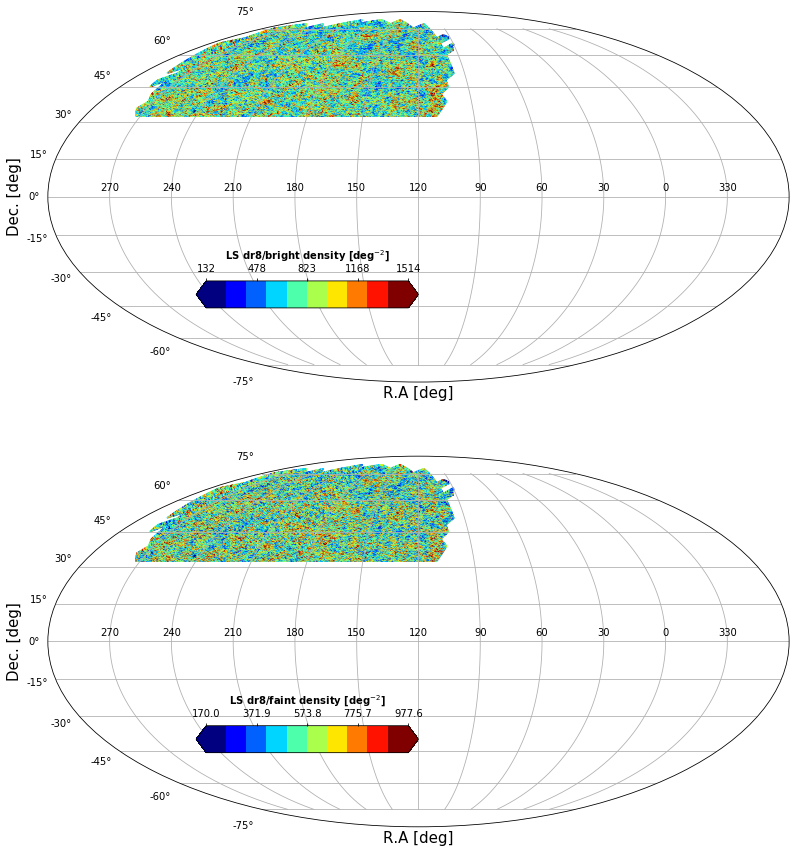

In [16]:
fig = plt.figure(figsize=(15, 15))
gs = gridspec.GridSpec(2,1)
    
org          = 120  # centre ra for mollweide plots
projection   = 'mollweide'
cm = mycmap(matplotlib.cm.jet, 10,0,1)
cmr= mycmap(matplotlib.cm.jet_r,10,0,1)

mollweide(hpdict=hpdict, namesel='bright', reg=reg, projection=projection, n=0, org=org, cm=cm, fig=fig, gs=gs, cval=None)
mollweide(hpdict=hpdict, namesel='faint', reg=reg, projection=projection, n=1, org=org, cm=cm, fig=fig, gs=gs, cval=None)
#mollweide(hpdict=hpdict, C=None ,namesel='any', reg='all', projection=projection, n=1, org=org, cm=cm, 
#          fig=fig, ws=ws, perc=(0.3,99.8), title='After linear weights', cval=(84, 2750))

file = '%s/skydens_%s_%s' %(pathdir, dr, reg)
fig.savefig(file+'.png', bbox_inches = 'tight', pad_inches = 0)


## Flow charts: Nominal & Galaxy View

In [17]:
#use below code to get target densities of keep and rejected at a particular stage in flowchart...
#use hpdict0 if density computed over the total area (before applyin spatial cuts in randoms)
#use hpdict if density computed over the reduced area (after applying spatial cuts in randoms)
if False:
    t = getStats(cat=cat, hpdict=hpdict0, bgsmask=bgsmask(), rancuts=rancuts, CurrentMask=['QC_FM', 'QC_FI', 'QC_FF'], 
             PrevMask=['BS', 'LG', 'GC', 'nobs', 'SG', 'FMC2', 'CC'], 
                 reg=reg, regcat=catinreg, regran=raninreg)

In [21]:
if reg == 'south': surveylab = 'DECaLS+DES'
elif reg == 'north': surveylab = 'BASS-MzLS'
elif reg == 'desi': surveylab = 'DESI'
else: surveylab = reg
    
flowTitle = dr+'_'+surveylab

#this is important to read the area of the proper region in hpdict0
region = reg

Previous Cuts: (None)
Current Cuts: (BS|LG|GC)
Previous Cuts: (BS|LG|GC)
Current Cuts: (nobs)
Previous Cuts: (BS|LG|GC|nobs)
Current Cuts: (SG)
Previous Cuts: (BS|LG|GC|nobs|SG)
Current Cuts: (FMC2|CC)
Previous Cuts: (BS|LG|GC|nobs|SG|FMC2|CC)
Current Cuts: (QC_FM|QC_FI|QC_FF)


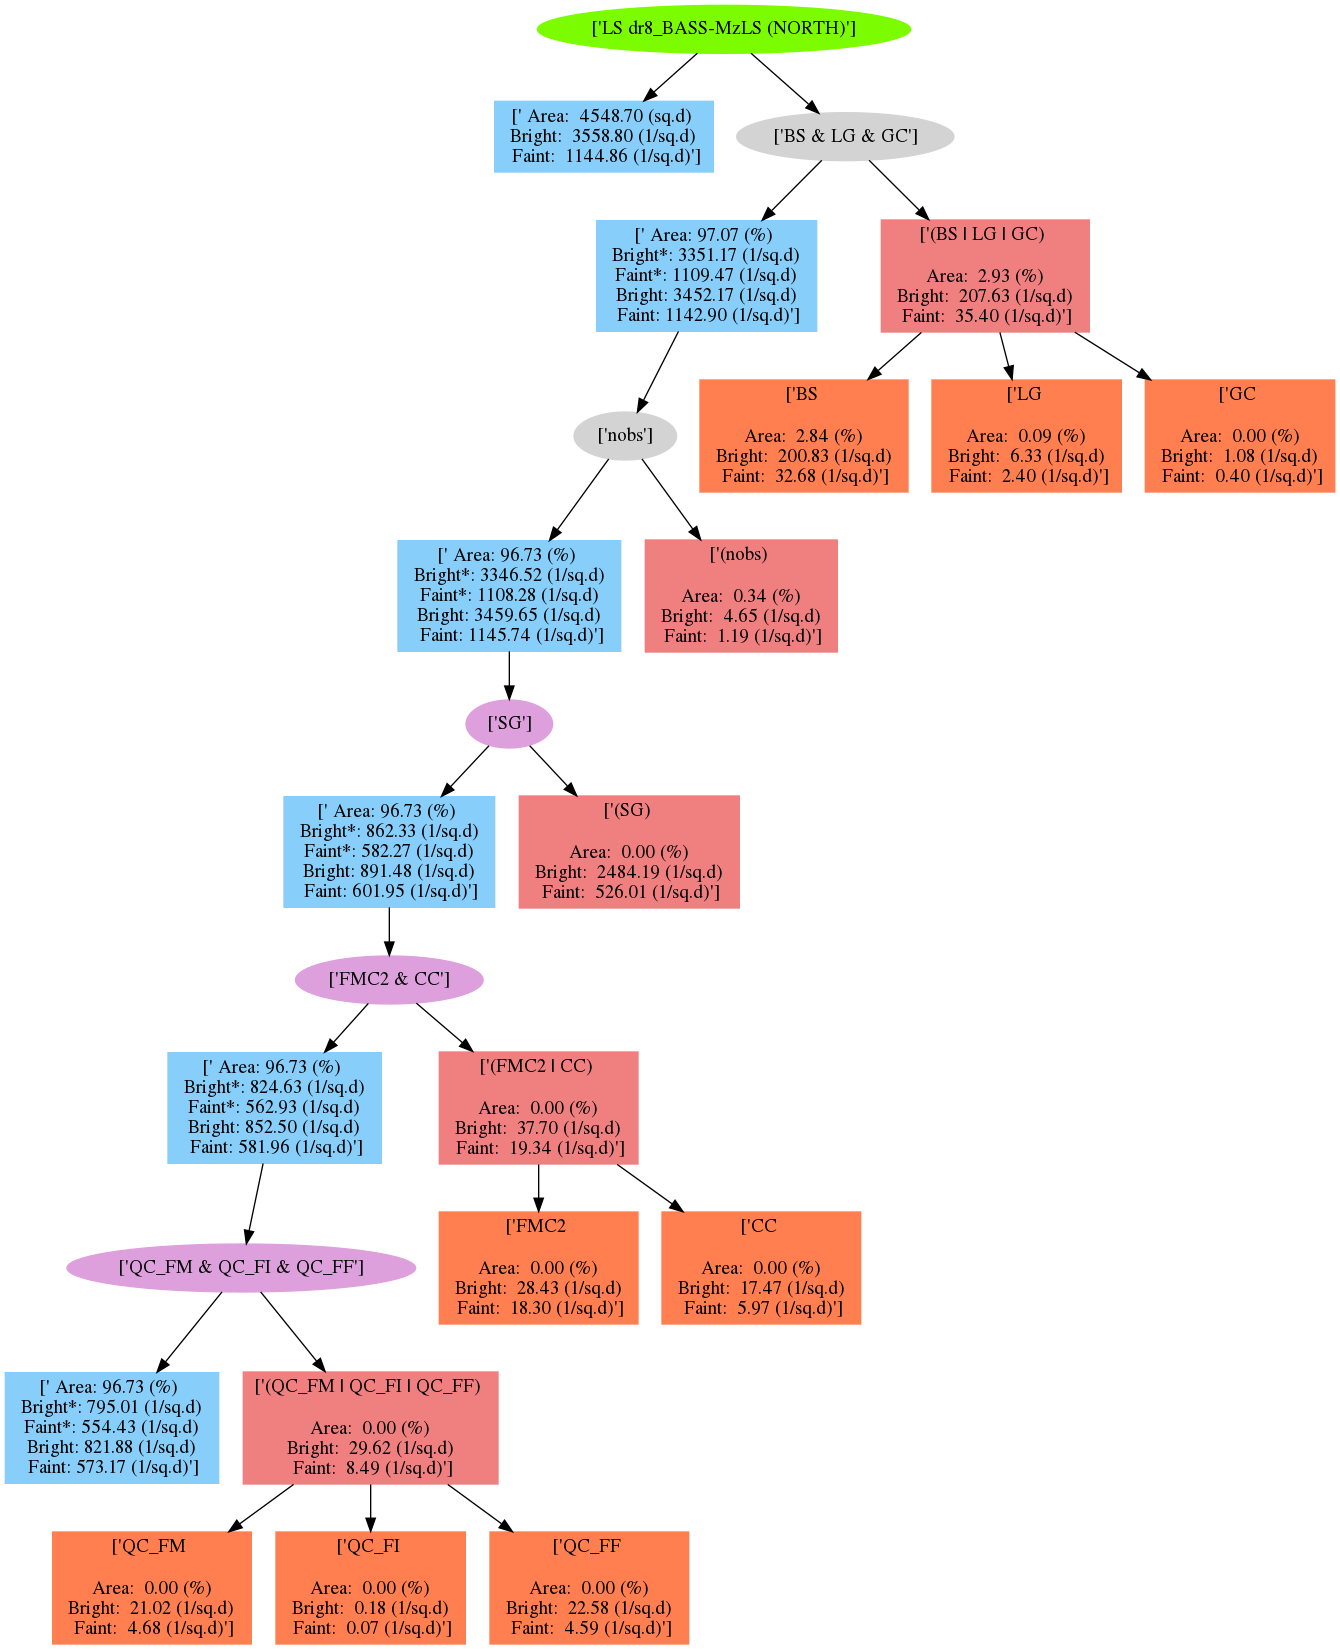

In [22]:
order = [['BS', 'LG', 'GC'], ['nobs'], ['SG'], ['FMC2', 'CC'], ['QC_FM', 'QC_FI', 'QC_FF']]


flowNominal, _, _ = flow(cat=cat, hpdict=hpdict0, bgsmask=bgsmask(), rancuts=rancuts, order=order, reg=region, 
             regcat=catinreg, regran=raninreg, file='%s/flow_main_nominal_%s' %(pathdir, flowTitle), dr=flowTitle, program='main')

flowNominal

In [ ]:
order = [ ['SG'], ['BS', 'LG', 'GC'], ['nobs'], ['QC_FM', 'QC_FI', 'QC_FF'], ['FMC2', 'CC']]

flowGalview, _, _ = flow(cat=cat, hpdict=hpdict0, bgsmask=bgsmask(), rancuts=rancuts, order=order, reg=region, 
             regcat=catinreg, regran=raninreg, file='%s/flow_main_galview_%s' %(pathdir,flowTitle), dr=flowTitle, program='main')

flowGalview

Previous Cuts: (None)
Current Cuts: (SG)
Previous Cuts: (SG)
Current Cuts: (BS|LG|GC)
Previous Cuts: (SG|BS|LG|GC)
Current Cuts: (nobs)


## 2D-stacks around Bright Stars and Medium Stars

Firs we do the stacking around the bright stars (`BS mask`) using BGS but `BS`. 

For the second stacking, we use BGS and do the stacking around the Medium Stars (`MS mask`).

In [ ]:
#star catalogue
stars = np.load('/global/cscratch1/sd/qmxp55/pauline/stars_GAIA_TYCHO_13.npy')

In [ ]:
hppix_stars = hp.ang2pix(nside,(90.-stars['DEC'])*np.pi/180.,stars['RA']*np.pi/180.,nest=True) # catalogue hp pixels array
starsinreg = get_reg(reg=reg, hppix=hppix_stars)
#cstars = SkyCoord(stars['RA']*units.degree,stars['DEC']*units.degree, frame='icrs')
#galb_stars = cstars.galactic.b.value # galb coordinate
stars = stars[(starsinreg) & (stars['DEC'] > -25)]

mag_radii MAX: 29.010052970495547 mag_radii MIN: 21.357112467941665
mag MAX: 12.99999713897705 mag MIN: 12.000000953674316
d2d min=0.00437, d2d max=18.7
density cumu (min, max): (nan, nan)
density non-cumu (min, max): (-8.9, 0.111)
88 of inf in density ratio out of a total of 16977
Minimum density ratio = -4.31009, Maximum density ratio = 1.04746
----------------


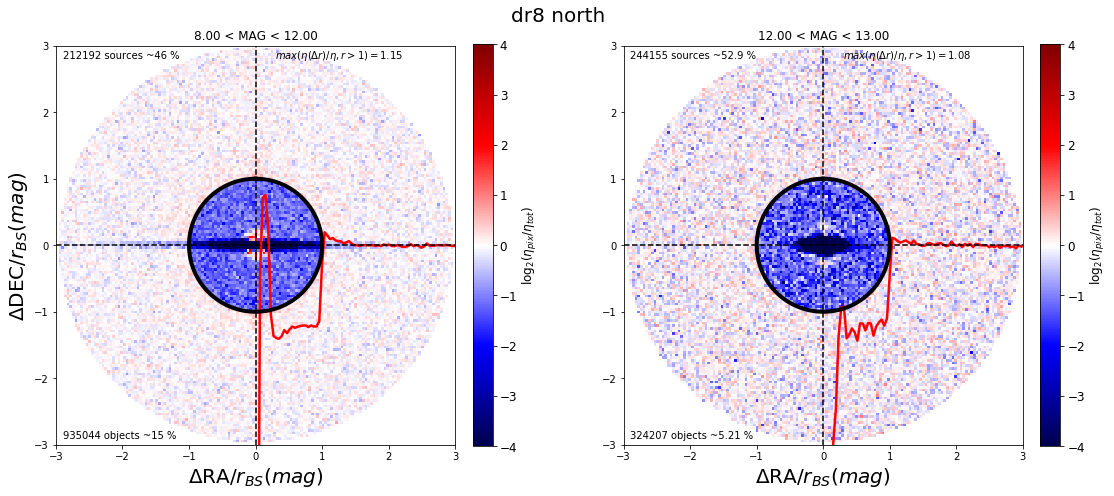

In [26]:
#
bgslist = ['LG', 'GC', 'nobs', 'SG', 'FMC2', 'CC', 'QC_FM', 'QC_FI', 'QC_FF']
    
# get BGS objects without BS bit set on
bgsbutBS = np.ones_like(cat['RA'], dtype=bool)

for key in bgslist:
    keep = ((cat['BGSBITS'] & 2**(bgsmask()[key])) != 0)
    bgsbutBS &= keep
bgsbutBS &= cat['RMAG'] < 20
    
log = True
nbins = 150
    
#Dustin_radii's
mag = np.linspace(0, 20, 50)
Dustin_MS_radii = []
for i,j in enumerate(mag):
    Dustin_MS_radii.append([j, np.minimum(1800., 150. * 2.5**((11. - j)/3.)) * 0.262/1])
        
plt.figure(figsize=(18, 8))
plt.title(r'%s %s' %(dr, survey), size=20)
plt.axis('off')
_ = overdensity(cat[bgsbutBS], stars, Dustin_MS_radii, 'MAG', 35, density=False, 
                        magbins=[8,12,13], radii_2=None, grid=[1,2], SR=[0., 400.], scaling=True, nbins=nbins, 
                               SR_scaling=3,logDenRat=[-4, 4], radii_bestfit=False, annulus=None, bintype='0', 
                                   filename='%s/2d_stack_BS_%s_%s' %(pathdir, dr, survey), log=log)


In [28]:
from io_ import get_msmask

#load mask sources objects from SWEEPS DR8
masksources = np.load('/global/cscratch1/sd/qmxp55/bgstargets_output/dr8/dr8_sweep_whole_maskbitsources.npy')

In [29]:
#get the medium bright stars
starsMS = get_msmask(masksources)

6584 nearby objects
12378075 Bright Stars


In [30]:
hppix_starsMS = hp.ang2pix(nside,(90.-starsMS['DEC'])*np.pi/180.,starsMS['RA']*np.pi/180.,nest=True) # catalogue hp pixels array
starsMSinreg = get_reg(reg=reg, hppix=hppix_starsMS)
#cstars = SkyCoord(stars['RA']*units.degree,stars['DEC']*units.degree, frame='icrs')
#galb_stars = cstars.galactic.b.value # galb coordinate
starsMS = starsMS[(starsMSinreg) & (starsMS['DEC'] > -25)]

13.00 < MAG < 14.00
mag_radii MAX: 21.35706050041543 mag_radii MIN: 15.745242910689122
mag MAX: 13.999999046325684 mag MIN: 13.000004768371582
d2d min=0.000765, d2d max=6.35
density cumu (min, max): (nan, nan)
density non-cumu (min, max): (-inf, 0.0858)
109 of inf in density ratio out of a total of 16977
Minimum density ratio = -4.37487, Maximum density ratio = 1.05139
----------------
14.00 < MAG < 15.00
mag_radii MAX: 15.745229503466572 mag_radii MIN: 11.599834873836398
mag MAX: 14.999999046325684 mag MIN: 14.000001907348633
d2d min=0.00038, d2d max=8.62
density cumu (min, max): (nan, nan)
density non-cumu (min, max): (-inf, 0.0795)
135 of inf in density ratio out of a total of 16977
Minimum density ratio = -4.3668, Maximum density ratio = 1.18779
----------------
15.00 < MAG < 16.00
mag_radii MAX: 11.599827908139646 mag_radii MIN: 8.544484463674413
mag MAX: 15.999999046325684 mag MIN: 15.000000953674316
d2d min= 0, d2d max=11.7
density cumu (min, max): (nan, nan)
density non-cumu (m

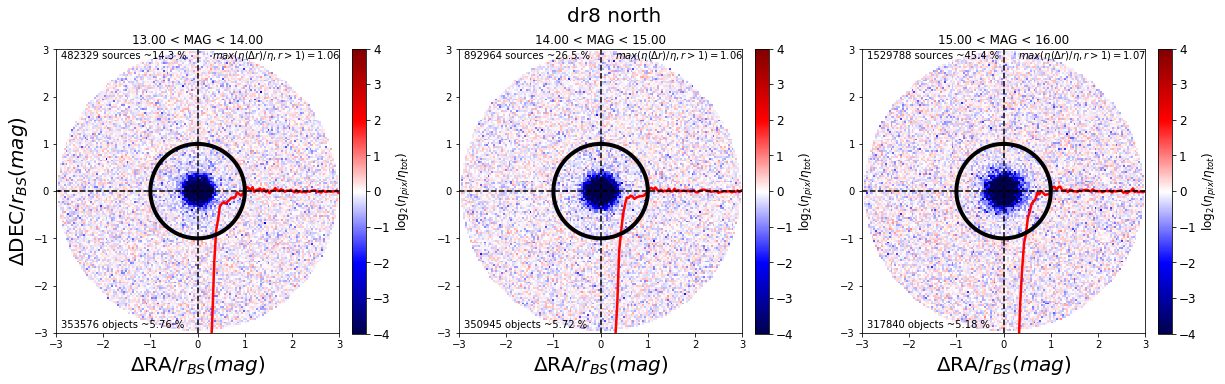

In [31]:
log = True
nbins = 150

bgs_any = ((cat['BGSBITS'] & 2**(20)) != 0)
        
plt.figure(figsize=(20, 6))
plt.title(r'%s %s' %(dr, survey), size=20)
plt.axis('off')
_ = overdensity(cat[bgs_any], starsMS, Dustin_MS_radii, 'MAG', 35, density=False, 
                        magbins=[13,14,15,16], radii_2=None, grid=[1,3], SR=[2., 100.], scaling=True, nbins=nbins, 
                               SR_scaling=3,logDenRat=[-4, 4], radii_bestfit=False, annulus=None, bintype='0', 
                                   filename='%s/2d_stack_MS_%s_%s' %(pathdir, dr, survey), log=log)

## Grr vs g-z: bgsbutSG

In [32]:
#bgslist = ['BS', 'LG', 'GC', 'nobs', 'FMC2', 'CC', 'QC_FM', 'QC_FI', 'QC_FF', 'QC_IVAR']
    
## get BGS objects without BS bit set on
#bgsbutSG = np.ones_like(cat['RA'], dtype=bool)

#for key in bgslist:
#    keep = ((cat['BGSBITS'] & 2**(bgsmask()[key])) != 0)
#    bgsbutSG &= keep
#bgsbutSG &= cat['RMAG'] < 20

bgsbutSG = bgsbut(bgsbits=cat['BGSBITS'], rmag=cat['RMAG'], pop=['SG'], bgsmask=bgsmask(), rlimit=20)

finite = np.ones_like(cat['RMAG'], dtype='?')
for i in ['RMAG', 'GMAG', 'ZMAG','FLUX_R', 'RFIBERMAG']:
    finite &= np.isfinite(cat[i])
    

In [33]:
Ared = hpdict['bgsarea_'+reg]

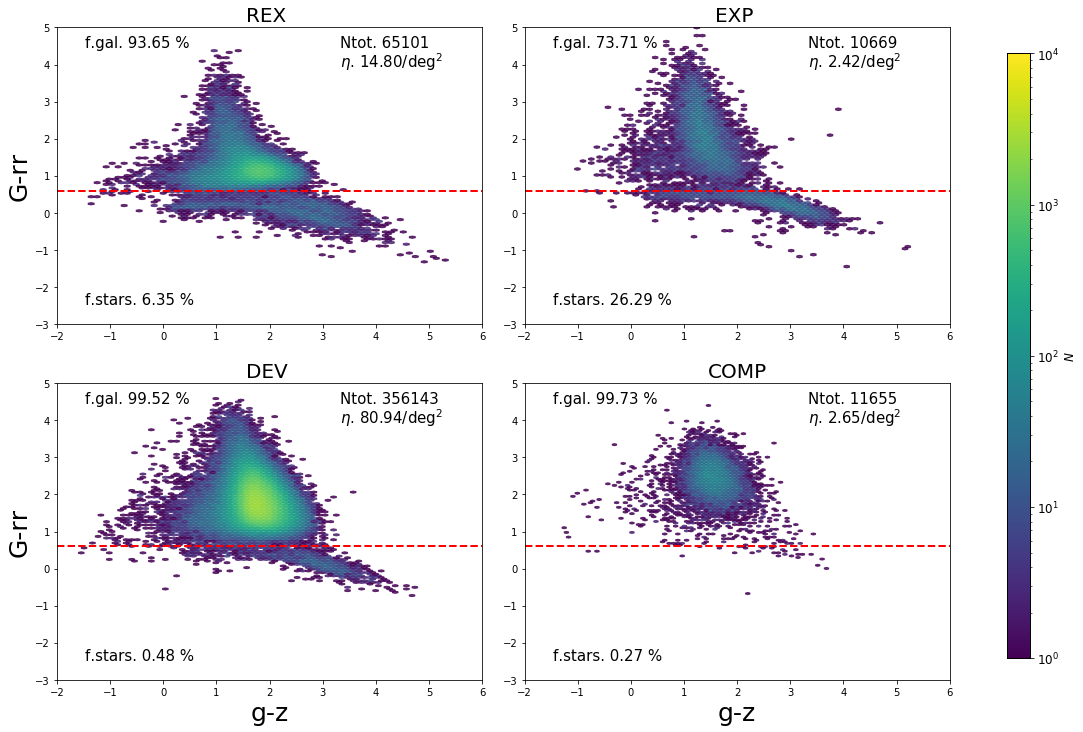

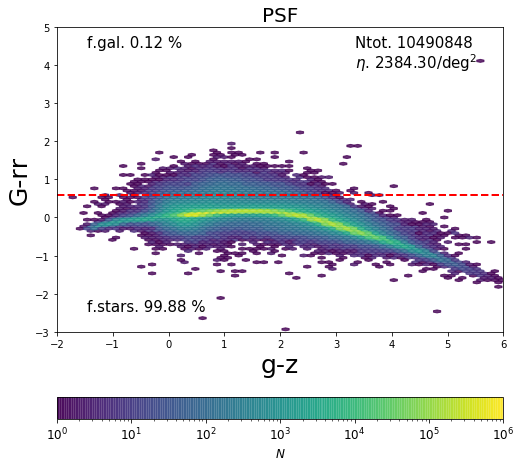

In [34]:
#
Grr = cat['G'] - flux_to_mag(cat['FLUX_R'])
coord = {'g-z':cat['GMAG'] - cat['ZMAG'], 'G-rr':Grr}
morphos = ['REX ', 'EXP ', 'DEV ', 'COMP']
rows, cols = 2, 2
#debug = cat['RMAG'] < 16
mask = (catinreg) & (bgsbutSG) & (finite) #& (debug)
hline, vline = 0.6, None
vmin, vmax = 1, None
    
fig    = plt.figure(figsize=(8*cols,6*rows))
gs     = gridspec.GridSpec(rows, cols, hspace=0.2, wspace=0.10)
    
for i, morpho in enumerate(morphos):
        
    if (i%cols==0): ylab=True
    else: ylab = False
    if morpho == 'PSF ': 
        vmax, cbar = None, 'vertical'
    else:
        vmax, cbar = 10000, 'panel'
        
    if i < 2: xlab = False
    else: xlab = True
        
    morphomask = cat['TYPE'] == morpho
    hexbin(coord=coord, catmask=((mask) & (morphomask)), n=i, bins='log', title=morpho, cmap='viridis', 
               ylab=ylab, xlab=xlab, vline=vline, hline=hline, fig=fig, gs=gs, vmin=vmin, vmax=vmax, mincnt=1, 
                   file='%s/gz_Grr_bgsbutSG_hexbin_extended_%s' %(pathdir, survey), fracs=True, area=Ared, cbar=cbar)

fig    = plt.figure(figsize=(8*1,8*1))
gs     = gridspec.GridSpec(1, 1, hspace=0.15, wspace=0.10)

hexbin(coord=coord, catmask=((mask) & (cat['TYPE'] == 'PSF ')), n=0, bins='log', title='PSF', cmap='viridis', 
               ylab=True, vline=vline, hline=hline, fig=fig, gs=gs, vmin=None, vmax=1000000, mincnt=1, 
                   file='%s/gz_Grr_bgsbutSG_hexbin_psf_%s' %(pathdir, survey), fracs=True, area=Ared, cbar='horizontal')
        

## rmag vs rfibmag: bgsbutFMC

In [35]:
#bgslist = ['BS', 'LG', 'GC', 'nobs', 'SG', 'CC', 'QC_FM', 'QC_FI', 'QC_FF', 'QC_IVAR']
    
## get BGS objects without BS bit set on
#bgsbutFMC2 = np.ones_like(cat['RA'], dtype=bool)

#for key in bgslist:
#    keep = ((cat['BGSBITS'] & 2**(bgsmask()[key])) != 0)
#    bgsbutFMC2 &= keep
#bgsbutFMC2 &= cat['RMAG'] < 20

bgsbutFMC2 = bgsbut(bgsbits=cat['BGSBITS'], rmag=cat['RMAG'], pop=['FMC2'], bgsmask=bgsmask(), rlimit=20)


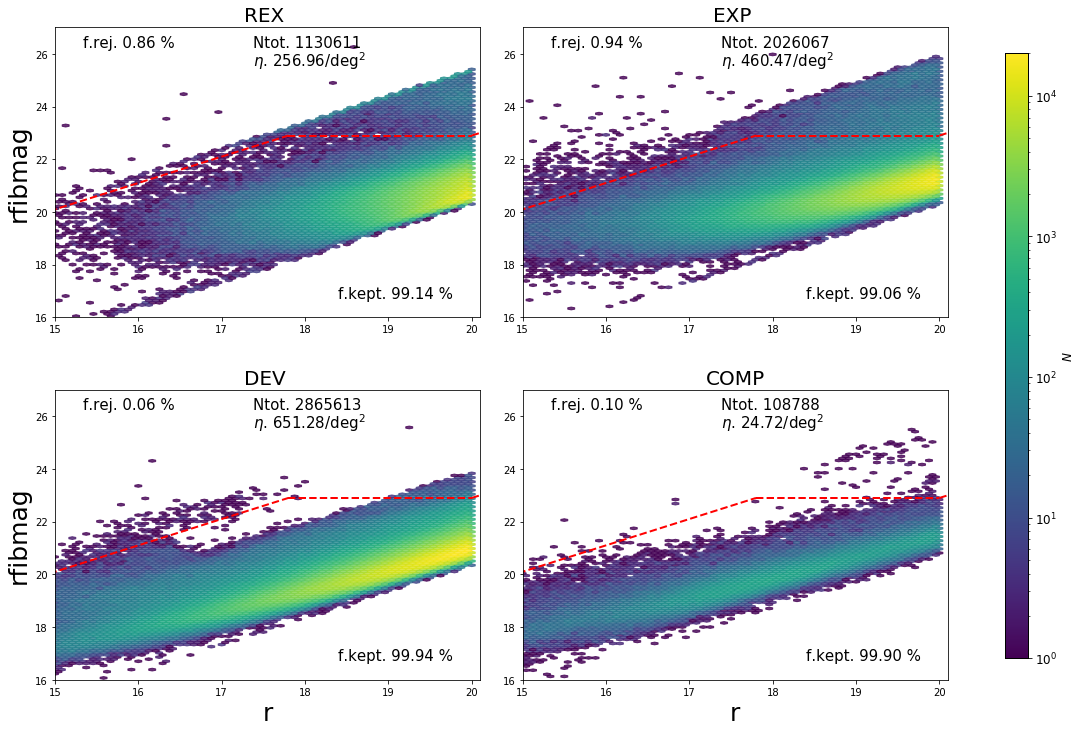

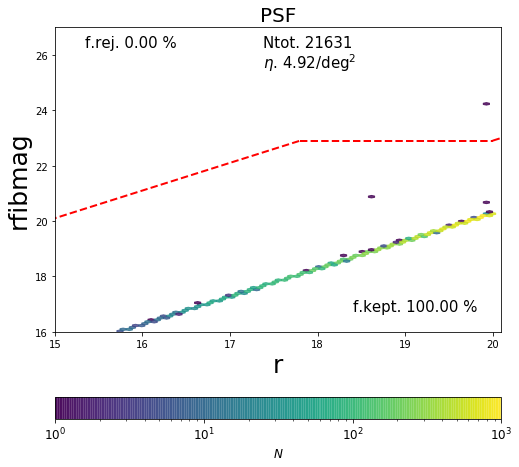

In [36]:
#
rows, cols = 2, 2
coord = {'r':cat['RMAG'], 'rfibmag':cat['RFIBERMAG']}
morphos = ['REX ', 'EXP ', 'DEV ', 'COMP']
#debug = cat['RMAG'] < 16
mask = (catinreg) & (bgsbutFMC2) & (finite) #& (debug)
hline, vline = None, None
vmin, vmax = 1, 20000
    
fig    = plt.figure(figsize=(8*cols,6*rows))
gs     = gridspec.GridSpec(rows, cols, hspace=0.25, wspace=0.10)
    
for i, morpho in enumerate(morphos):
        
    if (i%cols==0): ylab=True
    else: ylab = False
    if morpho == 'PSF ': 
        vmax, cbar = None, 'vertical'
    else:
        vmax, cbar = 20000, 'panel'
        
    if i < 2: xlab = False
    else: xlab = True
        
    morphomask = cat['TYPE'] == morpho
    hexbin(coord=coord, catmask=((mask) & (morphomask)), n=i, bins='log', title=morpho, cmap='viridis', 
               ylab=ylab, xlab=xlab, vline=vline, hline=hline, fig=fig, gs=gs, vmin=vmin, vmax=vmax, mincnt=1, fmcline=True, 
                   file='%s/r_rfibmag_bgsbutFMC2_hexbin_extended_%s' %(pathdir, survey), fracs=False, area=Ared, cbar=cbar)
    
    
fig    = plt.figure(figsize=(8*1,8*1))
gs     = gridspec.GridSpec(1, 1, hspace=0.15, wspace=0.10)

hexbin(coord=coord, catmask=((mask) & (cat['TYPE'] == 'PSF ')), n=0, bins='log', title='PSF', cmap='viridis', 
               ylab=True, vline=vline, hline=hline, fig=fig, gs=gs, vmin=None, vmax=1000, mincnt=1, fmcline=True,
                   file='%s/r_rfibmag_bgsbutFMC2_hexbin_psf_%s' %(pathdir, survey), fracs=False, area=Ared, cbar='horizontal')
        

## g-r vs r-z: bgsbutCC

In [37]:

bgsbutCC = bgsbut(bgsbits=cat['BGSBITS'], rmag=cat['RMAG'], pop=['CC'], bgsmask=bgsmask(), rlimit=20)


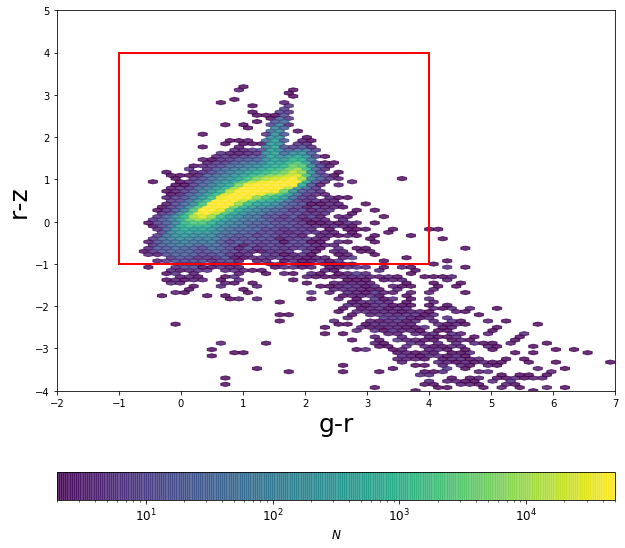

In [38]:
#
import matplotlib.patches as patches

coord = {'g-r':cat['GMAG'] - cat['RMAG'], 'r-z':cat['RMAG'] - cat['ZMAG']}
mask = (catinreg) & (bgsbutCC) & (finite) # & (cat['RMAG'] < 14)

fig   = plt.figure(figsize=(10,10))
gs     = gridspec.GridSpec(1, 1, hspace=0.15, wspace=0.10)


hexbin(coord=coord, catmask=mask, n=0, bins='log', title=None, cmap='viridis', 
               ylab=True, vline=None, hline=None, fig=fig, gs=gs, xlim=(-2, 7), ylim=(-4, 5), 
                   vmin=None, vmax=50000, mincnt=2, fmcline=False,
                       file=None, fracs=False, area=Ared, cbar='horizontal')

plt.plot(np.linspace(-1, 4, 3), np.full(3, -1), lw=2, c='r')
plt.plot(np.linspace(-1, 4, 3), np.full(3, 4), lw=2, c='r')

plt.plot(np.full(3, -1), np.linspace(-1, 4, 3), lw=2, c='r')
plt.plot(np.full(3, 4), np.linspace(-1, 4, 3), lw=2, c='r')

file='%s/gr_rz_bgsbutCC_hexbin_%s' %(pathdir, survey)
fig.savefig(file, bbox_inches = 'tight', pad_inches = 0)



## Venn diagrams: QCs

In [39]:
from QA import plot_venn3

In [42]:
# get BGS but QCs
bgsbutQCs = bgsbut(bgsbits=cat['BGSBITS'], rmag=cat['RMAG'], pop=['QC_FM', 'QC_FI', 'QC_FF'], bgsmask=bgsmask(), rlimit=20)
FM = ((cat['BGSBITS'] & 2**(11)) == 0) #rejects by FM
FI = ((cat['BGSBITS'] & 2**(12)) == 0) #rejects by FI
FF = ((cat['BGSBITS'] & 2**(13)) == 0) #rejects by FF
area = hpdict0['bgsarea_'+survey]

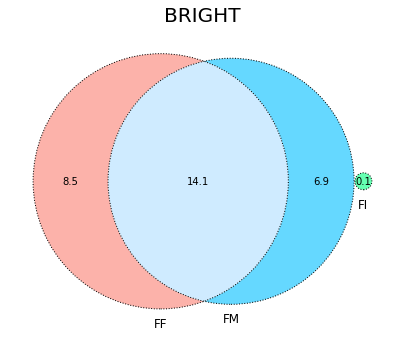

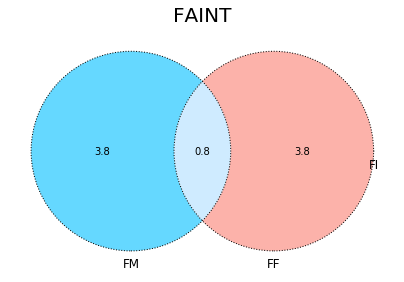

In [43]:
#
keepB = (bgsbutQCs) & (cat['RMAG'] < 19.5)
keepF = (bgsbutQCs) & (cat['RMAG'] > 19.5) & (cat['RMAG'] < 20)
plot_venn3(A=(keepB & FM), B=(keepB & FI), C=(keepB & FF), norm=area, 
           labels=['FM', 'FI', 'FF'], file=pathdir+'/venn_QCs_bright_%s' %(survey), title='BRIGHT', colors = ['deepskyblue', 'springgreen', 'salmon'])
plot_venn3(A=(keepF & FF), B=(keepF & FI), C=(keepF & FM), norm=area, 
           labels=['FF', 'FI', 'FM'], file=pathdir+'/venn_QCs_faint_%s' %(survey), title='FAINT', colors = ['salmon' ,'springgreen', 'deepskyblue'])


## Systematics

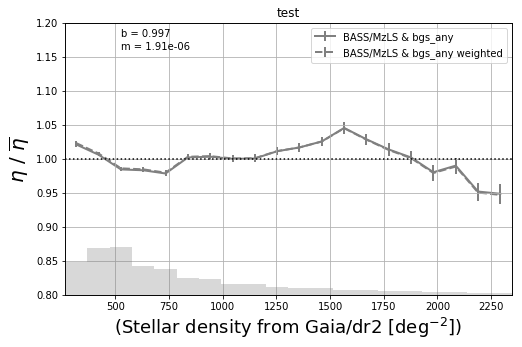

In [45]:
fig    = plt.figure(figsize=(18,5))
gs     = gridspec.GridSpec(1,2,hspace=0.30,wspace=0.25)
isdesi     = (hpdict['isdesi']) & (hpdict['bgsfracarea']>0) #this should be rename as "mainreg"
nx         = 20

b0, m0 = plot_sysdens(hpdicttmp=hpdict, namesels=['bgs_any'], regs=[reg], syst='stardens', mainreg=isdesi, xlim=None, n=0, nx=nx, clip=True, 
                         denslims=False, ylab=True, weights=True, fig=fig, gs=gs, title='test', label=True)

In [49]:
#dic WEIGHTED

ws = 1./((m0)*hpdict['stardens'] + b0)

hpdict_ws = get_dict(cat=cat, pixmapfile=dr8pix, hppix_ran=hppix_ran, hppix_cat=hppix_cat, 
                      maskrand=((rancuts['BS']) & (rancuts['GC']) & (rancuts['LG']) & (rancuts['nobs'])),
                          maskcat=None, 
                             Nranfiles=Nranfiles, ranindesi=ranindesi, catindesi=None, 
                                desifootprint=True, namesels={'bgs_any':20, 'bright':21, 'faint':22}, 
                                  galb=cat_ex['b'], log=True, survey='bgs', ws=ws)

positions and desifotprint DONE...
systematics DONE...
randdens =  15000  ; len randoms =  68230483
bgsfracarea DONE...
regions DONE...
areas DONE...
computing for  north / bgs_any
computing for  north / bright
computing for  north / faint
target densities in north DONE...
computing for  south / bgs_any
computing for  south / bright
computing for  south / faint
target densities in south DONE...
meandens_bgs_any_all = 1398 /deg2
meandens_bgs_any_des = nan /deg2
meandens_bgs_any_decals = nan /deg2
meandens_bgs_any_north = 1398 /deg2
meandens_bgs_any_south = nan /deg2
meandens_bgs_any_svfields = 1370 /deg2
meandens_bgs_any_svfields_n = 1370 /deg2
meandens_bgs_any_svfields_s = nan /deg2
meandens_bright_all = 824 /deg2
meandens_bright_des = nan /deg2
meandens_bright_decals = nan /deg2
meandens_bright_north = 824 /deg2
meandens_bright_south = nan /deg2
meandens_bright_svfields = 798 /deg2
meandens_bright_svfields_n = 798 /deg2
meandens_bright_svfields_s = nan /deg2
meandens_faint_all = 574 /

In [50]:
from QA import pixhistregs

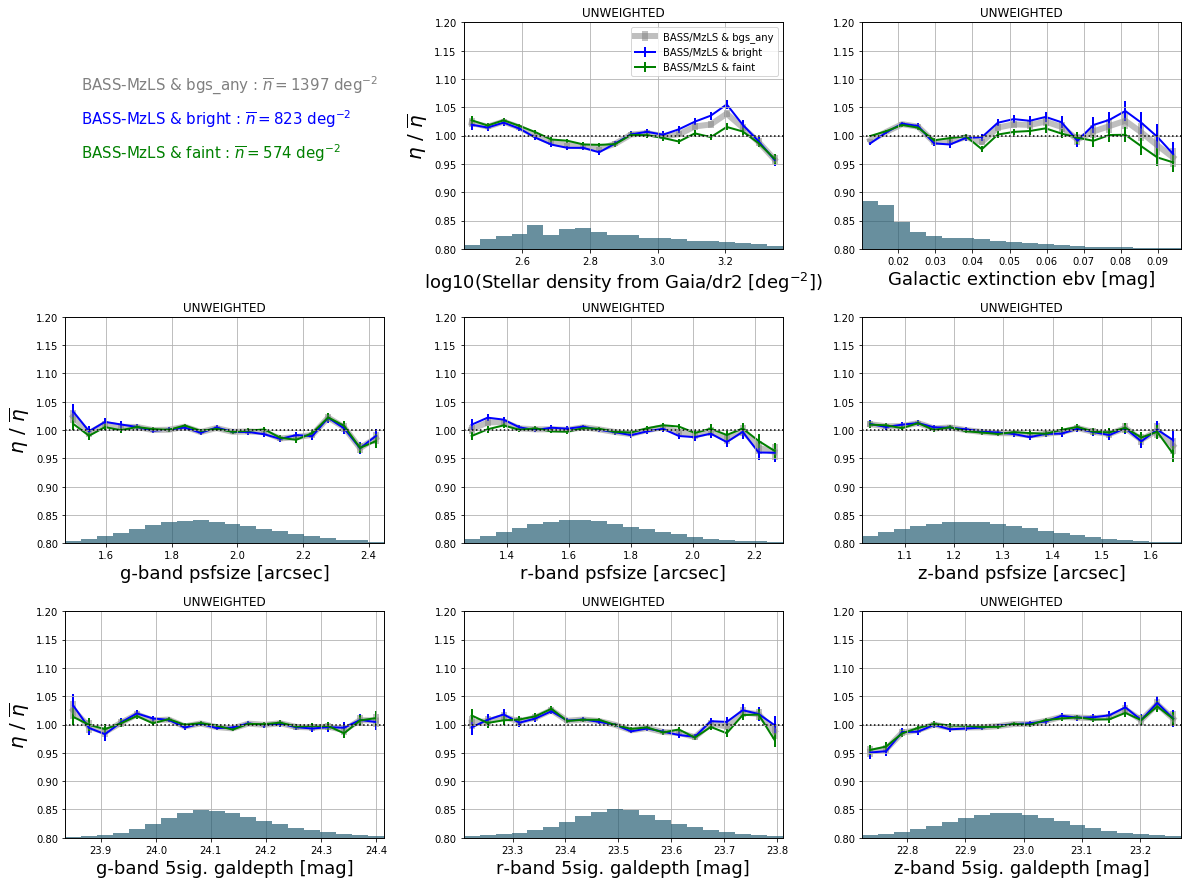

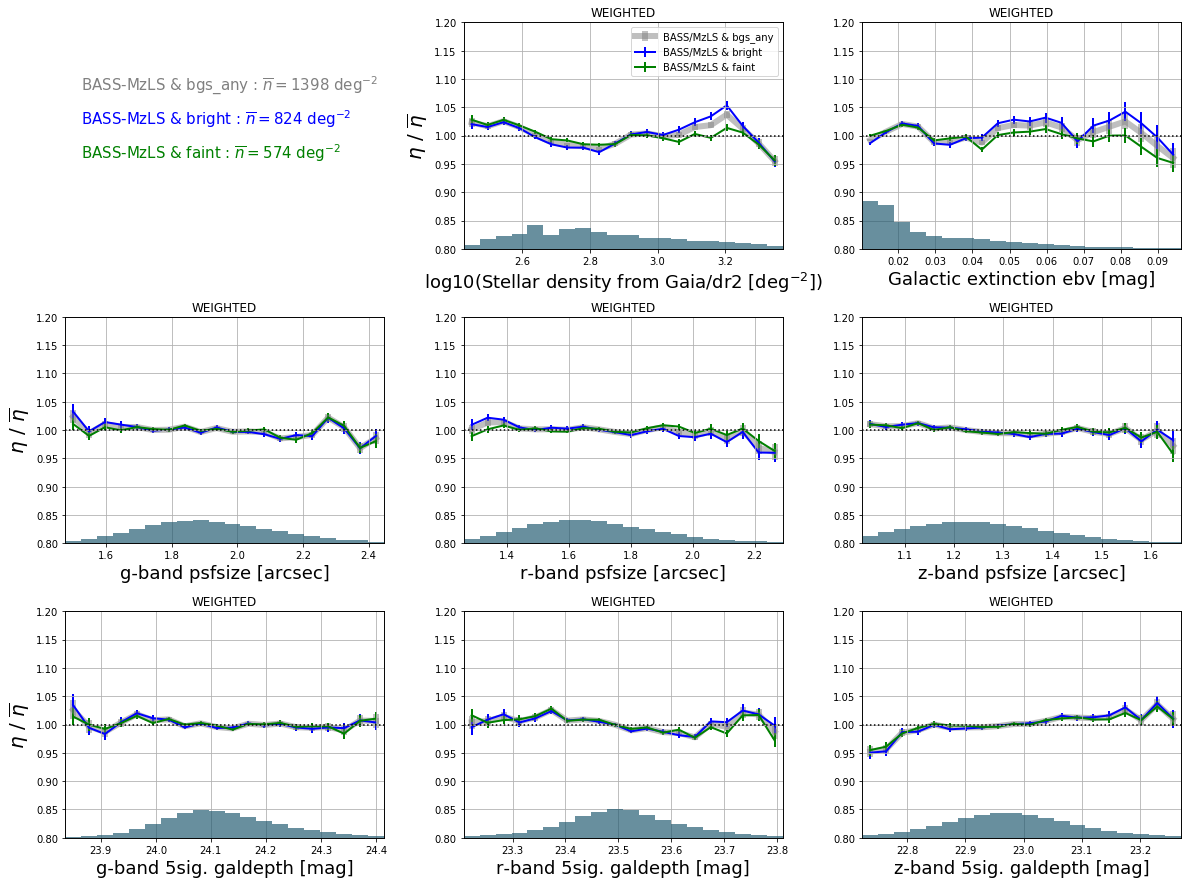

In [51]:
# dr8_south+north : density distributions + systematics

# settings
isdesi     = (hpdict['isdesi']) & (hpdict['bgsfracarea']>0) #this should be rename as "mainreg"
systs      = ['log10_stardens','ebv','psfsize_g', 'psfsize_r', 'psfsize_z','galdepth_g', 'galdepth_r', 'galdepth_z']
nx         = 20
cols       = ['0.5','b','g','r']    
#regs = [reg]
namesels=['bgs_any', 'bright', 'faint']
#

# looping on subselections
#for key, title in zip([None, ws], ['UNWEIGHTED', 'WEIGHTED']):
for key, title in zip([hpdict, hpdict_ws], ['UNWEIGHTED', 'WEIGHTED']):
    
    # systematics
    fig    = plt.figure(figsize=(20,15))
    gs     = gridspec.GridSpec(3,3,hspace=0.30,wspace=0.25)
        
    for i in range(len(systs)+1):
        
        if i == 0:
            axinfo = fig.add_subplot(gs[i])
            # infos
            axinfo.axis('off')
            #axinfo.text(0.5,0.9,namesel,fontsize=20,fontweight='bold',ha='center',transform=axinfo.transAxes)
            tmpy = 0.7
            #for regi,col in zip(regs,cols):
            #if reg == 'south':reg_ = 'DECaLS+DES'
            #else: reg_ = reg
            for namesel,col in zip(namesels,cols):
                tmpstr = surveylab+' & '+namesel+' : '+r'$\overline{n}=$'+'%.0f'%key['meandens_'+namesel+'_'+reg]+r' deg$^{-2}$'
                axinfo.text(0.05,tmpy,tmpstr,color=col,fontsize=15,transform=axinfo.transAxes)
                tmpy  -= 0.15
        else:
            syst = systs[i-1]
            if (i%3==0) or (i==1): ylab=True
            else: ylab = False
            if i == 1: label = True
            else: label = False
            #if title == 'UNWEIGHTED': 
            #    weights = False
            #    onlyweights=False
            #else: 
            #    weights = True
            #    onlyweights=True
                
            plot_sysdens(hpdicttmp=key, namesels=namesels, regs=[reg], syst=syst, mainreg=isdesi, xlim=None, n=i, nx=nx, clip=True, 
                         denslims=False, ylab=ylab, weights=False, fig=fig, gs=gs, label=label, title=title, 
                             ws=None)
    
    # save fig
    fig.savefig('%s/systematics_main_bgs_%s_%s.png' %(pathdir, survey, title), bbox_inches = 'tight', pad_inches = 0)
    print('')
    print('')

### Systematics separated by best model fitted

In [19]:
namesels = {}
for i in ['COMP', 'DEV ', 'EXP ', 'PSF ', 'REX ']:
    namesels[i] = (cat['TYPE'] == i) & (bgs_any)

In [20]:
hpdict_tmp = get_dict(cat=cat, pixmapfile=dr8pix, hppix_ran=hppix_ran, hppix_cat=hppix_cat, 
                      maskrand=((rancuts['BS']) & (rancuts['GC']) & (rancuts['LG']) & (rancuts['nobs'])),
                          maskcat=None, 
                             Nranfiles=Nranfiles, ranindesi=ranindesi, catindesi=None, 
                                desifootprint=True, namesels=namesels, galb=cat_ex['b'], log=True, survey='custom')

positions and desifotprint DONE...
systematics DONE...
randdens =  15000  ; len randoms =  145754705
bgsfracarea DONE...
regions DONE...
areas DONE...
computing for  north / COMP
computing for  north / DEV 
computing for  north / EXP 
computing for  north / PSF 
computing for  north / REX 
target densities in north DONE...
computing for  south / COMP
computing for  south / DEV 
computing for  south / EXP 
computing for  south / PSF 
computing for  south / REX 
target densities in south DONE...
meandens_COMP_all = 31 /deg2
meandens_COMP_des = 50 /deg2
meandens_COMP_decals = 28 /deg2
meandens_COMP_north = nan /deg2
meandens_COMP_south = 31 /deg2
meandens_COMP_svfields = 34 /deg2
meandens_COMP_svfields_n = nan /deg2
meandens_COMP_svfields_s = 34 /deg2
meandens_DEV _all = 630 /deg2
meandens_DEV _des = 650 /deg2
meandens_DEV _decals = 627 /deg2
meandens_DEV _north = nan /deg2
meandens_DEV _south = 630 /deg2
meandens_DEV _svfields = 655 /deg2
meandens_DEV _svfields_n = nan /deg2
meandens_DEV

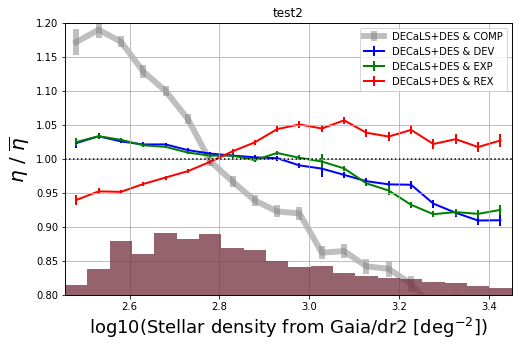

In [27]:
fig    = plt.figure(figsize=(18,5))
gs     = gridspec.GridSpec(1,2,hspace=0.30,wspace=0.25)
isdesi     = (hpdict_tmp['isdesi']) & (hpdict_tmp['bgsfracarea']>0)

plot_sysdens(hpdicttmp=hpdict_tmp, namesels=['COMP', 'DEV ', 'EXP ', 'REX '], regs=[reg], 
                 syst='log10_stardens', mainreg=isdesi, xlim=None, n=0, nx=20, clip=True, 
                         denslims=False, ylab=True, weights=False, fig=fig, gs=gs, title='test2', label=True)

### Systematics separated by rmag bins

In [30]:
namesels = {}
mags = np.linspace(16, 20, 9)
for i in range(len(mags[:-1])):
    namesels['%s_%s' %(str(mags[i]), str(mags[i+1]))] = (cat['RMAG'] > mags[i]) & (cat['RMAG'] < mags[i+1]) & (bgs_any)

In [31]:
namesels.keys()

dict_keys(['16.0_16.5', '16.5_17.0', '17.0_17.5', '17.5_18.0', '18.0_18.5', '18.5_19.0', '19.0_19.5', '19.5_20.0'])

In [32]:
hpdict_tmp = get_dict(cat=cat, pixmapfile=dr8pix, hppix_ran=hppix_ran, hppix_cat=hppix_cat, 
                      maskrand=((rancuts['BS']) & (rancuts['GC']) & (rancuts['LG']) & (rancuts['nobs'])),
                          maskcat=None, 
                             Nranfiles=Nranfiles, ranindesi=ranindesi, catindesi=None, 
                                desifootprint=True, namesels=namesels, galb=cat_ex['b'], log=True, survey='custom')

positions and desifotprint DONE...
systematics DONE...
randdens =  15000  ; len randoms =  145754705
bgsfracarea DONE...
regions DONE...
areas DONE...
computing for  north / 16.0_16.5
computing for  north / 16.5_17.0
computing for  north / 17.0_17.5
computing for  north / 17.5_18.0
computing for  north / 18.0_18.5
computing for  north / 18.5_19.0
computing for  north / 19.0_19.5
computing for  north / 19.5_20.0
target densities in north DONE...
computing for  south / 16.0_16.5
computing for  south / 16.5_17.0
computing for  south / 17.0_17.5
computing for  south / 17.5_18.0
computing for  south / 18.0_18.5
computing for  south / 18.5_19.0
computing for  south / 19.0_19.5
computing for  south / 19.5_20.0
target densities in south DONE...
meandens_16.0_16.5_all = 12 /deg2
meandens_16.0_16.5_des = 12 /deg2
meandens_16.0_16.5_decals = 12 /deg2
meandens_16.0_16.5_north = nan /deg2
meandens_16.0_16.5_south = 12 /deg2
meandens_16.0_16.5_svfields = 11 /deg2
meandens_16.0_16.5_svfields_n = nan 

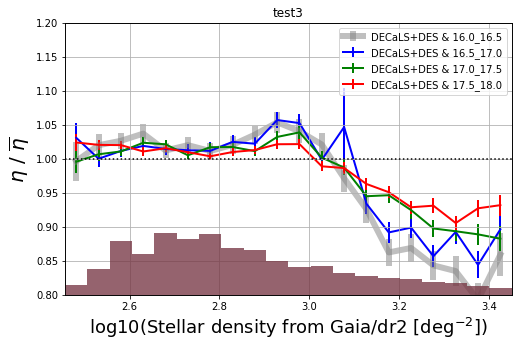

In [33]:
fig    = plt.figure(figsize=(18,5))
gs     = gridspec.GridSpec(1,2,hspace=0.30,wspace=0.25)
isdesi     = (hpdict_tmp['isdesi']) & (hpdict_tmp['bgsfracarea']>0)

plot_sysdens(hpdicttmp=hpdict_tmp, namesels=['16.0_16.5', '16.5_17.0', '17.0_17.5', '17.5_18.0'], regs=[reg], 
                 syst='log10_stardens', mainreg=isdesi, xlim=None, n=0, nx=20, clip=True, 
                         denslims=False, ylab=True, weights=False, fig=fig, gs=gs, title='test3', label=True)

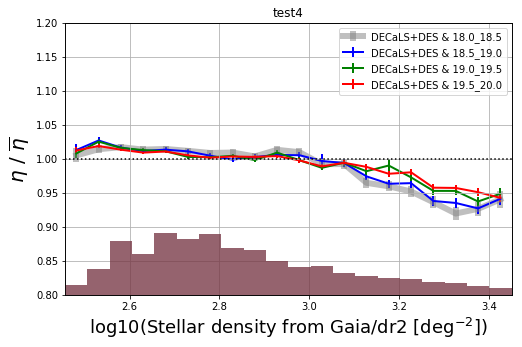

In [34]:
fig    = plt.figure(figsize=(18,5))
gs     = gridspec.GridSpec(1,2,hspace=0.30,wspace=0.25)
isdesi     = (hpdict_tmp['isdesi']) & (hpdict_tmp['bgsfracarea']>0)

plot_sysdens(hpdicttmp=hpdict_tmp, namesels=['18.0_18.5', '18.5_19.0', '19.0_19.5', '19.5_20.0'], regs=[reg], 
                 syst='log10_stardens', mainreg=isdesi, xlim=None, n=0, nx=20, clip=True, 
                         denslims=False, ylab=True, weights=False, fig=fig, gs=gs, title='test4', label=True)

## AEN vs G-rr star-galaxy classification in GAIA

Tractor force to fit as PSF the GAIA objects that satisfy the following conditions:

* For $G<19$: astrometric_excess_noise $< 10^{0.5}$, 

* For $G≥19$: astrometric_excess_noise $ < 10^{0.5+0.2(G−19)}$.
    
G is the GAIA photometric $G$-band and the astrometric excess noise ($AEN$) is the...
Those PSF that are in GAIA are treated as Stars according to TRACTOR and the GAIA objects that do not fulfill that condition are treated as GALAXIES. This is different to the way we do star-galaxy separation for BGS, we use GAIA but rather than look at the $AEN$ we look at the colour distribution $G-rr$.

The PSF GAIA objects (from above definition) are treated differently than other PSF objects and they have a local fitting, the problem is that maybe those are not stars and might be galaxies instead that photometry is being altered by this local fitting.

Here we are going to find out what are the differences between our star-galaxy classification and the one above for GAIA objects.
We're going to:

* $Grr$ distributions for $Grr$ class and $AEN$ class:
    * All
    * TRACTOR PSF
    * TRACTOR No PSF
* Heat maps
* Venn diagram's
* Galleries of mismatches divided in `TRACTOR PSF` and `TRACTOR non-PSF`:
    * Stars with $Grr$ class and Galaxies with $AEN$ class
    * Galaxies with $Grr$ class and Stars with $AEN$ class

In [12]:
inGAIA = (cat['REF_CAT'] == 'G2') & (cat['RMAG'] < 20)
grr_gal = ((cat['BGSBITS'] & 2**(6)) != 0) & (cat['RMAG'] < 20)
grr_stars = ((cat['BGSBITS'] & 2**(6)) == 0) & (cat['RMAG'] < 20)
AEN_star, AEN_gal = gaiaAEN(inGAIA=inGAIA, size=len(cat['RA']), G=cat['G'], AEN=cat['AEN'])
PSF = (cat['TYPE'] == 'PSF ')

#inGAIA2 = (cat['G'] != 0)

In [33]:
set(cat['TYPE'][:10000])

{'COMP', 'DEV ', 'EXP ', 'PSF ', 'REX '}

In [34]:
np.sum((mask2) & (bgs_any) & (np.log10(cat['AEN']) > 0.5) & (cat['TYPE'] == 'PSF '))

15

(10, 22)

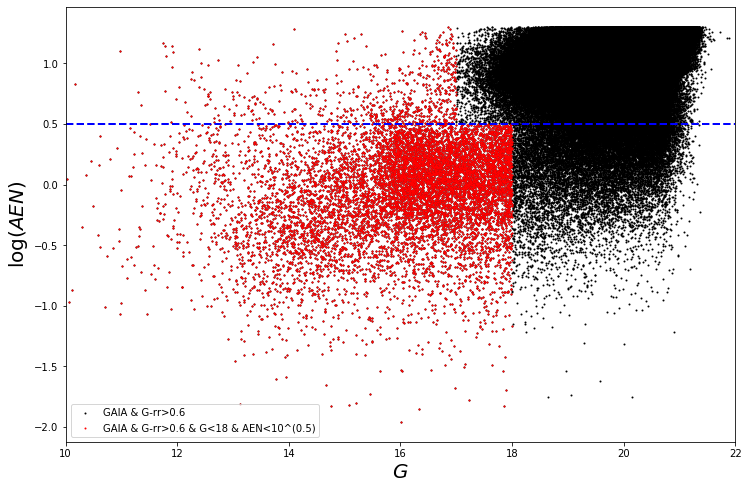

In [26]:
plt.figure(figsize=(12, 8))
mask = (inGAIA) & (grr_gal)
mask2 = (mask) & (np.logical_or(cat['G'] < 17, (cat['G'] < 18)*(np.log10(cat['AEN']) < 0.5)))
plt.scatter(cat['G'][mask], np.log10(cat['AEN'])[mask], s=1, c='k', label='GAIA & G-rr>0.6')
plt.scatter(cat['G'][mask2], np.log10(cat['AEN'])[mask2], s=1, c='r', label='GAIA & G-rr>0.6 & G<18 & AEN<10^(0.5)')
plt.axhline(0.5, lw=2, ls='--', color='b')
plt.legend()
plt.xlabel(r'$G$', size=20)
plt.ylabel(r'$\log(AEN)$', size=20)
plt.xlim(10, 22)


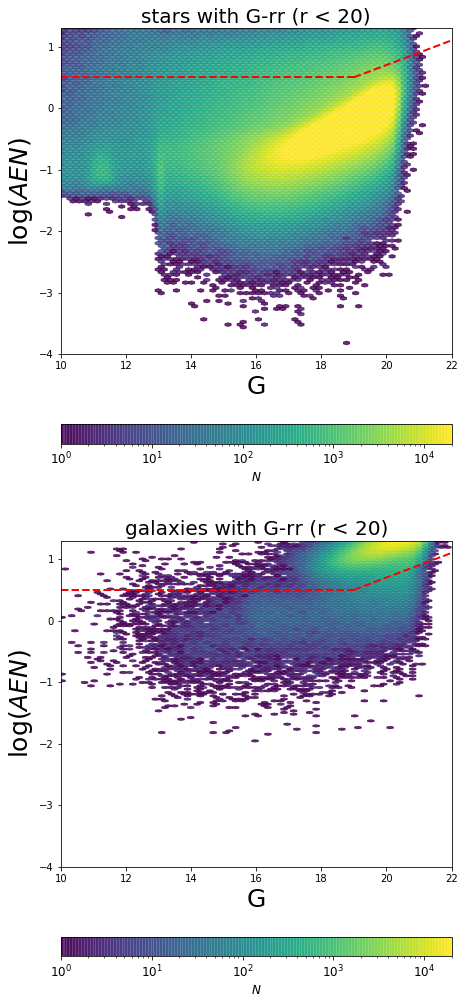

In [13]:
#
coord = {'G':cat['G'], r'$\log(AEN)$':np.log10(cat['AEN'])}
#masks = [(grr_stars) & (inGAIA) & (cat['RMAG'] < 14), (grr_gal) & (inGAIA) & (cat['RMAG'] < 14)]
masks = [(grr_stars) & (inGAIA), (grr_gal) & (inGAIA)]
titles = ['stars with G-rr (r < 20)', 'galaxies with G-rr (r < 20)']
vmin, vmax = 1, 20000
    
fig    = plt.figure(figsize=(7,9*len(masks)))
gs     = gridspec.GridSpec(len(masks), 1,hspace=0.1,wspace=0.10)
    
for i, mask in enumerate(masks):
        
    #if (i%len(masks)==0): xlab=True
    #else: xlab = False
    #if morpho == 'PSF ': vmax = None
        
    #morphomask = cat['TYPE'] == morpho
    hexbin(coord=coord, catmask=mask, n=i, bins='log', title=titles[i], cmap='viridis', xlab=True,
               ylab=True, vline=None, hline=None, fig=fig, gs=gs, vmin=vmin, vmax=vmax, mincnt=1, fmcline=False, 
                   file=None, area=None, xlim=[10, 22], ylim=[-4, 1.3], cbar='horizontal')
    
    #if i == 0:
    #    x, y = coord.keys()
    #    mask1 = (gaia_star) & (dr8_gama) & (dr8_z > 0.002) & (bgs)
    #    mask2 = (gaia_star) & (dr8_gama) & (dr8_z > 0.002) & (~bgs)
    #    plt.scatter(coord[x][mask2], coord[y][mask2], s=2, c='royalblue', label=r'Not in BGS')
    #    plt.scatter(coord[x][mask1], coord[y][mask1], s=2, c='k', label=r'in BGS')
    #    plt.legend()
    
    x_N1 = np.linspace(10, 19, 4)
    x_N2 = np.linspace(19, 22, 4)
    plt.plot(x_N1, x_N1*0+0.5, color='r', ls='--', lw=2)
    plt.plot(x_N2, 0.5 + 0.2*(x_N2 - 19.), color='r', ls='--', lw=2)

file = pathdir+'/G_logAEN'
fig.savefig(file+'.png', bbox_inches = 'tight', pad_inches = 0)

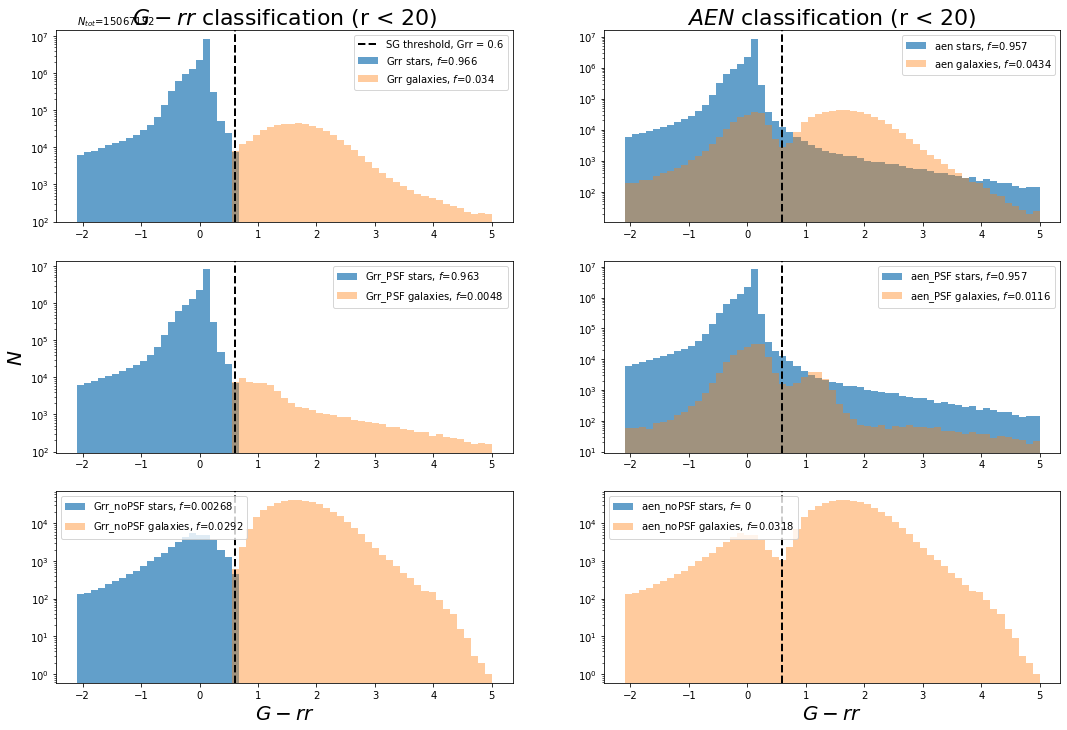

In [54]:
#
fig = plt.figure(figsize=(18,12))

log = True
Grr = cat['G'] - flux_to_mag(cat['FLUX_R'])

classes = {'stars_Grr':(grr_stars) & (inGAIA), 'gal_Grr':(grr_gal) & (inGAIA), 'stars_aen': (AEN_star) & (cat['RMAG'] < 20), 'gal_aen':(AEN_gal) & (cat['RMAG'] < 20), 
              'stars_Grr_PSF':(grr_stars) & (inGAIA) & (PSF), 'gal_Grr_PSF':(grr_gal) & (inGAIA) & (PSF),
                  'stars_aen_PSF':(AEN_star) & (PSF) & (cat['RMAG'] < 20), 'gal_aen_PSF':(AEN_gal) & (PSF) & (cat['RMAG'] < 20),
                      'stars_Grr_noPSF':(grr_stars) & (inGAIA) & (~PSF), 'gal_Grr_noPSF':(grr_gal) & (inGAIA) & (~PSF),
                          'stars_aen_noPSF':(AEN_star) & (~PSF) & (cat['RMAG'] < 20), 'gal_aen_noPSF':(AEN_gal) & (~PSF) & (cat['RMAG'] < 20)}

for i, j in enumerate(['Grr', 'aen', 'Grr_PSF', 'aen_PSF', 'Grr_noPSF', 'aen_noPSF']):

    XS = (classes['stars_' + j])
    XG = (classes['gal_' + j])
    tot_gaia = np.sum((inGAIA))

    plt.subplot(3, 2, i+1)
    
    if i == 0:
        plt.title(r'$G-rr$ classification (r < 20)', size=22)
    if i == 1:
        plt.title(r'$AEN$ classification (r < 20)', size=22)
    
    bins = np.linspace(-2.1, 5, 60)
        
    plt.hist(Grr[XS], bins=bins, log=log, alpha=0.7, label='%s stars, $f$=%2.3g' %(j, np.sum(XS)/tot_gaia))
    plt.hist(Grr[XG], bins=bins, log=log, alpha=0.4, label='%s galaxies, $f$=%2.3g' %(j, np.sum(XG)/tot_gaia))
    if i == 0:
        plt.axvline(0.6, ls='--', lw=2, c='k', label='SG threshold, Grr = 0.6')
        plt.text(-2.1, 2*10**7, '$N_{tot}$=%s' %(tot_gaia))
    plt.axvline(0.6, ls='--', lw=2, c='k')
    if (i == 4) or (i == 5):
        plt.xlabel(r'$G-rr$', size=20)
    if i == 2:
        plt.ylabel(r'$N$', size=20)    
    plt.legend()

plt.show()
filename = '%s/gaia_Grr_comparison_with_aen' %(pathdir)
fig.savefig(filename+'.png') #bbox_inches = 'tight', pad_inches = 0


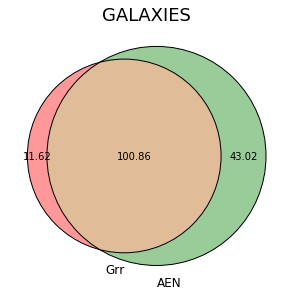

In [55]:
from matplotlib_venn import venn2, venn2_circles

fig = plt.figure(figsize=(5,5))

sf = 2
area = hpdict0['bgsarea_'+survey]

a = classes['gal_Grr']
b = classes['gal_aen']
c = (a) & (b)

a1 = round(((np.sum(a) - np.sum(c))/area), sf)
b1 = round(((np.sum(b) - np.sum(c))/area), sf)
c1 = round(np.sum(c)/area, sf)

plt.title(r'GALAXIES', size=18)
labels = ('Grr', 'AEN')
   
venn2([a1, b1, c1], set_labels = labels)
c=venn2_circles([a1, b1, c1], linestyle='solid', linewidth=1, color="k")

filename = '%s/venn_gaia_Grr_comparison_with_aen' %(pathdir)
fig.savefig(filename+'.png', bbox_inches = 'tight', pad_inches = 0) 


In [17]:
ls_b = (cat['RMAG'] < 19.5)

np.sum(bgs_b)/np.sum(ls_b)

0.21197147700695868

# DEV ZONE

In [68]:
#bgslist = ['BS', 'LG', 'GC', 'nobs', 'FMC2', 'CC', 'QC_FM', 'QC_FI', 'QC_FF', 'QC_IVAR']
bgsbut20 = bgsbut(bgsbits=cat['BGSBITS'], rmag=cat['RMAG'], pop=['QC_FM','QC_FI','QC_FF','QC_IVAR', 'FMC2', 'CC', 'nobs', 'BS', 'LG', 'GC'], bgsmask=bgsmask(), rlimit=20)
bgsbut201 = bgsbut(bgsbits=cat['BGSBITS'], rmag=cat['RMAG'], pop=['QC_FM','QC_FI','QC_FF','QC_IVAR', 'FMC2', 'CC', 'nobs', 'BS', 'LG', 'GC'], bgsmask=bgsmask(), rlimit=20.1)
bgsbut205 = bgsbut(bgsbits=cat['BGSBITS'], rmag=cat['RMAG'], pop=['QC_FM','QC_FI','QC_FF','QC_IVAR', 'FMC2', 'CC', 'nobs', 'BS', 'LG', 'GC'], bgsmask=bgsmask(), rlimit=20.5)
bgsbut207 = bgsbut(bgsbits=cat['BGSBITS'], rmag=cat['RMAG'], pop=['QC_FM','QC_FI','QC_FF','QC_IVAR', 'FMC2', 'CC', 'nobs', 'BS', 'LG', 'GC'], bgsmask=bgsmask(), rlimit=20.7)
#bgsbutCC = bgsbut(bgsbits=cat['BGSBITS'], rmag=cat['RMAG'], pop=['CC'], bgsmask=bgsmask())
#bgsbutFMC2 = bgsbut(bgsbits=cat['BGSBITS'], rmag=cat['RMAG'], pop=['FMC2'], bgsmask=bgsmask())
#bgsbutBSLG = bgsbut(bgsbits=cat['BGSBITS'], rmag=cat['RMAG'], pop=['BS', 'LG'], bgsmask=bgsmask())

In [43]:
bgs_any = ((cat['BGSBITS'] & 2**(20)) != 0)

In [69]:
namesels = {}
#namesels['bgs_any'] = bgs_any
namesels['bgsbut20'] = bgsbut20
namesels['bgsbut201'] = bgsbut201
namesels['bgsbut205'] = bgsbut205
namesels['bgsbut207'] = bgsbut207

In [70]:
#dic with default BGS selection and in DESI footprint
#maskrand=((rancuts['BS']) & (rancuts['GC']) & (rancuts['LG']) & (rancuts['nobs']))
hpdict_tmp = get_dict(cat=cat, pixmapfile=dr8pix, hppix_ran=hppix_ran, hppix_cat=hppix_cat, 
                      maskrand=None,
                          maskcat=None, 
                             Nranfiles=Nranfiles, ranindesi=ranindesi, catindesi=None, 
                                desifootprint=True, namesels=namesels, galb=galb, log=True, survey='custom')

positions and desifotprint DONE...
systematics DONE...
randdens =  15000  ; len randoms =  145754705
bgsfracarea DONE...
regions DONE...
areas DONE...
computing for  north / bgsbut20
computing for  north / bgsbut201
computing for  north / bgsbut205
computing for  north / bgsbut207
target densities in north DONE...
computing for  south / bgsbut20
computing for  south / bgsbut201
computing for  south / bgsbut205
computing for  south / bgsbut207
target densities in south DONE...
meandens_bgsbut20_all = 1452 /deg2
meandens_bgsbut20_des = 1442 /deg2
meandens_bgsbut20_decals = 1453 /deg2
meandens_bgsbut20_north = nan /deg2
meandens_bgsbut20_south = 1452 /deg2
meandens_bgsbut20_svfields = 1466 /deg2
meandens_bgsbut20_svfields_n = nan /deg2
meandens_bgsbut20_svfields_s = 1466 /deg2
meandens_bgsbut201_all = 1608 /deg2
meandens_bgsbut201_des = 1596 /deg2
meandens_bgsbut201_decals = 1610 /deg2
meandens_bgsbut201_north = nan /deg2
meandens_bgsbut201_south = 1608 /deg2
meandens_bgsbut201_svfields =

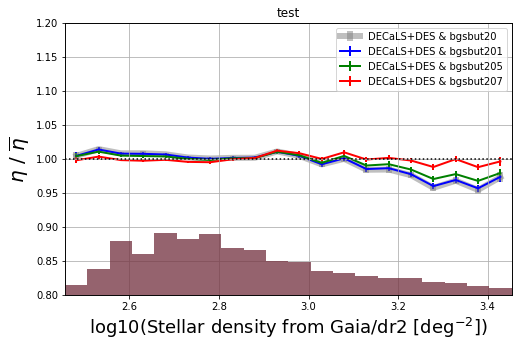

In [71]:
fig    = plt.figure(figsize=(18,5))
gs     = gridspec.GridSpec(1,2,hspace=0.30,wspace=0.25)
isdesi     = (hpdict_tmp['isdesi']) & (hpdict_tmp['bgsfracarea']>0)

plot_sysdens(hpdicttmp=hpdict_tmp, namesels=['bgsbut20', 'bgsbut201', 'bgsbut205', 'bgsbut207'], regs=[reg], 
                 syst='log10_stardens', mainreg=isdesi, xlim=None, n=0, nx=20, clip=True, 
                         denslims=False, ylab=True, weights=False, fig=fig, gs=gs, title='test', label=True)

#plot_sysdens(hpdicttmp=hpdict_tmp, namesels=[ 'bgs_19.0_19.5', 'bgs_19.5_20.0'], regs=[reg], syst='log10_stardens', mainreg=isdesi, xlim=None, n=1, nx=nx, clip=True, 
#                         denslims=False, ylab=True, weights=False, fig=fig, gs=gs, title='test', label=True)


In [73]:
#bgslist = ['BS', 'LG', 'GC', 'nobs', 'FMC2', 'CC', 'QC_FM', 'QC_FI', 'QC_FF', 'QC_IVAR']
bgsbut20 = bgsbut(bgsbits=cat['BGSBITS'], rmag=cat['RMAG'], pop=None, bgsmask=bgsmask(), rlimit=20)
bgsbut201 = bgsbut(bgsbits=cat['BGSBITS'], rmag=cat['RMAG'], pop=None, bgsmask=bgsmask(), rlimit=20.1)
bgsbut205 = bgsbut(bgsbits=cat['BGSBITS'], rmag=cat['RMAG'], pop=None, bgsmask=bgsmask(), rlimit=20.5)
bgsbut207 = bgsbut(bgsbits=cat['BGSBITS'], rmag=cat['RMAG'], pop=None, bgsmask=bgsmask(), rlimit=20.7)

In [74]:
namesels = {}
namesels['bgsbut20'] = bgsbut20
namesels['bgsbut201'] = bgsbut201
namesels['bgsbut205'] = bgsbut205
namesels['bgsbut207'] = bgsbut207

In [75]:
#dic with default BGS selection and in DESI footprint
#maskrand=((rancuts['BS']) & (rancuts['GC']) & (rancuts['LG']) & (rancuts['nobs']))
hpdict_tmp = get_dict(cat=cat, pixmapfile=dr8pix, hppix_ran=hppix_ran, hppix_cat=hppix_cat, 
                      maskrand=((rancuts['BS']) & (rancuts['GC']) & (rancuts['LG']) & (rancuts['nobs'])),
                          maskcat=None, 
                             Nranfiles=Nranfiles, ranindesi=ranindesi, catindesi=None, 
                                desifootprint=True, namesels=namesels, galb=galb, log=True, survey='custom')

positions and desifotprint DONE...
systematics DONE...
randdens =  15000  ; len randoms =  145754705
bgsfracarea DONE...
regions DONE...
areas DONE...
computing for  north / bgsbut20
computing for  north / bgsbut201
computing for  north / bgsbut205
computing for  north / bgsbut207
target densities in north DONE...
computing for  south / bgsbut20
computing for  south / bgsbut201
computing for  south / bgsbut205
computing for  south / bgsbut207
target densities in south DONE...
meandens_bgsbut20_all = 1426 /deg2
meandens_bgsbut20_des = 1430 /deg2
meandens_bgsbut20_decals = 1425 /deg2
meandens_bgsbut20_north = nan /deg2
meandens_bgsbut20_south = 1426 /deg2
meandens_bgsbut20_svfields = 1437 /deg2
meandens_bgsbut20_svfields_n = nan /deg2
meandens_bgsbut20_svfields_s = 1437 /deg2
meandens_bgsbut201_all = 1578 /deg2
meandens_bgsbut201_des = 1583 /deg2
meandens_bgsbut201_decals = 1578 /deg2
meandens_bgsbut201_north = nan /deg2
meandens_bgsbut201_south = 1578 /deg2
meandens_bgsbut201_svfields =

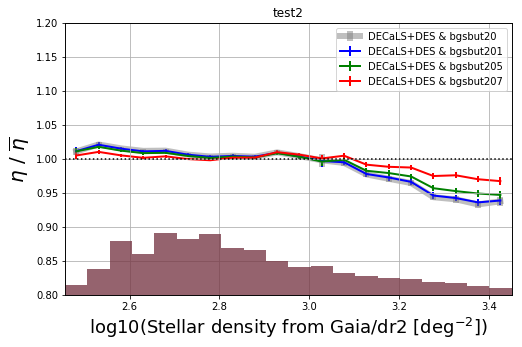

In [76]:
fig    = plt.figure(figsize=(18,5))
gs     = gridspec.GridSpec(1,2,hspace=0.30,wspace=0.25)
isdesi     = (hpdict_tmp['isdesi']) & (hpdict_tmp['bgsfracarea']>0)

plot_sysdens(hpdicttmp=hpdict_tmp, namesels=['bgsbut20', 'bgsbut201', 'bgsbut205', 'bgsbut207'], regs=[reg], 
                 syst='log10_stardens', mainreg=isdesi, xlim=None, n=0, nx=20, clip=True, 
                         denslims=False, ylab=True, weights=False, fig=fig, gs=gs, title='test2', label=True)

#plot_sysdens(hpdicttmp=hpdict_tmp, namesels=[ 'bgs_19.0_19.5', 'bgs_19.5_20.0'], regs=[reg], syst='log10_stardens', mainreg=isdesi, xlim=None, n=1, nx=nx, clip=True, 
#                         denslims=False, ylab=True, weights=False, fig=fig, gs=gs, title='test', label=True)


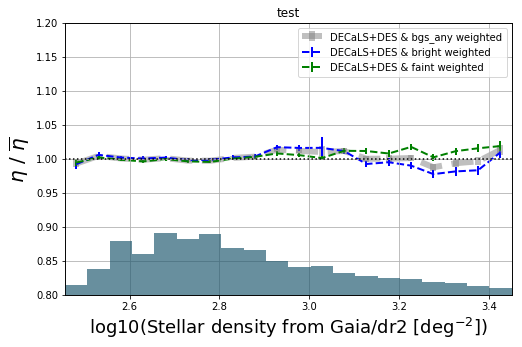

In [80]:
#
ws = 1./((-3.96*10**(-5))*hpdict['stardens'] + 1.03)

fig    = plt.figure(figsize=(18,5))
gs     = gridspec.GridSpec(1,2,hspace=0.30,wspace=0.25)

plot_sysdens(hpdicttmp=hpdict, namesels=['bgs_any', 'bright', 'faint'], regs=[reg], syst='log10_stardens', mainreg=isdesi, xlim=None, n=0, nx=nx, clip=True, 
                         denslims=False, ylab=True, weights=True, fig=fig, gs=gs, title='test', label=True, ws=ws, onlyweights=True)

In [88]:
hpdict['meandens_bgs_any_south']

1425.646415390457

In [89]:
hpdict_tmp['meandens_bgs_any_south']

1432.660001909052

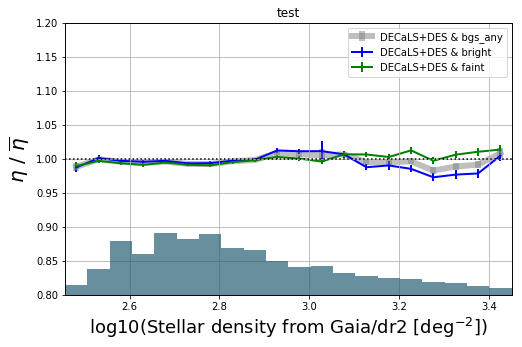

In [90]:
#
#ws = 1./((-3.96*10**(-5))*hpdict['stardens'] + 1.03)

fig    = plt.figure(figsize=(18,5))
gs     = gridspec.GridSpec(1,2,hspace=0.30,wspace=0.25)

plot_sysdens(hpdicttmp=hpdict_tmp, namesels=['bgs_any', 'bright', 'faint'], regs=[reg], syst='log10_stardens', mainreg=isdesi, xlim=None, n=0, nx=nx, clip=True, 
                         denslims=False, ylab=True, weights=False, fig=fig, gs=gs, title='test', label=True, ws=None, onlyweights=False)

In [53]:
bgs_any = ((cat['BGSBITS'] & 2**(20)) != 0)
namesels = {}
mags = [15, 18, 18.5, 19.0, 19.5, 20.0]
for num,i in enumerate(mags[:-1]):
    namesels['bgs_%s_%s' %(str(mags[num]), str(mags[num+1]))] = (bgs_any) & (cat['RMAG'] > mags[num]) & (cat['RMAG'] < mags[num+1])
    

In [55]:
#dic with default BGS selection and in DESI footprint
hpdict_tmp = get_dict(cat=cat, pixmapfile=dr8pix, hppix_ran=hppix_ran, hppix_cat=hppix_cat, 
                      maskrand=((rancuts['BS']) & (rancuts['GC']) & (rancuts['LG']) & (rancuts['nobs'])),
                          maskcat=None, 
                             Nranfiles=Nranfiles, ranindesi=ranindesi, catindesi=None, 
                                desifootprint=True, namesels=namesels, galb=galb, log=True, survey='custom')

positions and desifotprint DONE...
systematics DONE...
randdens =  15000  ; len randoms =  145754705
bgsfracarea DONE...
regions DONE...
areas DONE...
computing for  north / bgs_15_18
computing for  north / bgs_18_18.5
computing for  north / bgs_18.5_18.5
computing for  north / bgs_18.5_19.0
computing for  north / bgs_19.0_19.5
computing for  north / bgs_19.5_20.0
target densities in north DONE...
computing for  south / bgs_15_18
computing for  south / bgs_18_18.5
computing for  south / bgs_18.5_18.5
computing for  south / bgs_18.5_19.0
computing for  south / bgs_19.0_19.5
computing for  south / bgs_19.5_20.0
target densities in south DONE...
meandens_bgs_15_18_all = 154 /deg2
meandens_bgs_15_18_des = 153 /deg2
meandens_bgs_15_18_decals = 154 /deg2
meandens_bgs_15_18_north = nan /deg2
meandens_bgs_15_18_south = 154 /deg2
meandens_bgs_15_18_svfields = 151 /deg2
meandens_bgs_15_18_svfields_n = nan /deg2
meandens_bgs_15_18_svfields_s = 151 /deg2
meandens_bgs_18_18.5_all = 124 /deg2
meande

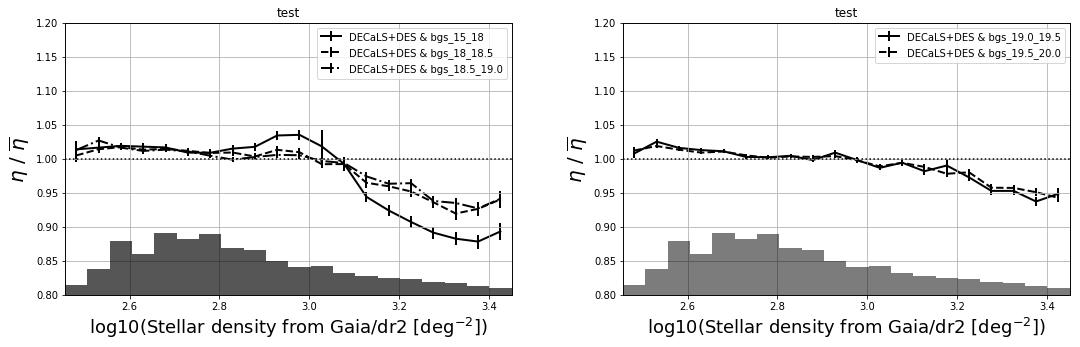

In [60]:
fig    = plt.figure(figsize=(18,5))
gs     = gridspec.GridSpec(1,2,hspace=0.30,wspace=0.25)

plot_sysdens(hpdicttmp=hpdict_tmp, namesels=['bgs_15_18', 'bgs_18_18.5', 'bgs_18.5_19.0'], regs=[reg], syst='log10_stardens', mainreg=isdesi, xlim=None, n=0, nx=nx, clip=True, 
                         denslims=False, ylab=True, weights=False, fig=fig, gs=gs, title='test', label=True)

plot_sysdens(hpdicttmp=hpdict_tmp, namesels=[ 'bgs_19.0_19.5', 'bgs_19.5_20.0'], regs=[reg], syst='log10_stardens', mainreg=isdesi, xlim=None, n=1, nx=nx, clip=True, 
                         denslims=False, ylab=True, weights=False, fig=fig, gs=gs, title='test', label=True)


In [ ]:
bgs_bright = ((cat['BGSBITS'] & 2**(21)) != 0)
bgs_faint = ((cat['BGSBITS'] & 2**(22)) != 0)
bgs_any = ((cat['BGSBITS'] & 2**(20)) != 0)